In [1]:
%matplotlib inline
import math
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, expon, gamma, norm, pearsonr
from itertools import groupby, cycle
from operator import itemgetter
from sklearn import metrics
from IPython.display import Markdown, display
import ipywidgets
mpl.rcParams['figure.dpi'] = 300

In [2]:
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.latex.repr', True)
# pd.set_option('display.latex.longtable', True)

# CAID
## Dataset
Critical Assessment of Intrinsic Disorder (CAID) is a continuous experiment where prediction methods for intrinsic disorder (ID) are blind tested on unpublished DisProt data.

In [3]:
reference_path = '/home/marnec/Projects/CAID/caid/data/disorder/'
prediction_path = '/home/marnec/Projects/CAID/caid/data/results/'
baseline_dir = '/home/marnec/Projects/CAID/caid/baseline'
results_dir = '/home/marnec/Projects/CAID/caid/results'
labels_path = '/home/marnec/Projects/CAID/caid/caid/'


ref_widget = ipywidgets.RadioButtons(
    options={r.split('_')[0]
             for r in os.listdir(reference_path)},
    description="Reference:",
    disabled=False,
    value='new-disprot-all')

neg_widget = ipywidgets.RadioButtons(options={
    r.split('_')[1].split('.')[0]
    for r in os.listdir(reference_path)
},
                                     description="Reference:",
                                     disabled=False,
                                     value='simple')

opt_widget = ipywidgets.RadioButtons(options=['Default', 'ROC', 'Fmax'],
                                     description="Reference:",
                                     disabled=False,
                                     value='Default')

accordion = ipywidgets.Accordion(children=[ref_widget, neg_widget, opt_widget])
accordion.set_title(0, 'Reference')
accordion.set_title(1, 'Negatives')
accordion.set_title(2, 'Threshold optimization')
accordion

Accordion(children=(RadioButtons(description='Reference:', index=6, options=('new-pdb-missing', 'new-disprot-s…

In [5]:
style_widget = ipywidgets.ToggleButtons(
    options=['Explorative', 'Slides', 'Publication'],
    description='Plot style:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    value="Slides"
)
style_widget

ToggleButtons(description='Plot style:', index=1, options=('Explorative', 'Slides', 'Publication'), value='Sli…

In [30]:
reference = ref_widget.value
negatives = neg_widget.value
thr_optimization = opt_widget.value
style = style_widget.value
reference_fullpath = os.path.join(reference_path, "{}_{}.txt".format(reference, negatives))

labels_codes = json.load(open(labels_path + "caid_codes.json"))
labels_names = json.load(open(labels_path + "caid_names.json"))

labels_codes_f = lambda k: labels_codes.get(k, k)
labels_names_f = lambda k: labels_names.get(k, k)

In [7]:
def get_ref_dict(ref_file):
    """Load reference in dict. Disprot are used as keys"""
    ref = {}
    with open(ref_file) as f:
        faiter = (x[1] for x in groupby(f, lambda line: line[0] == ">"))
        for header in faiter:
            header = next(header)
            if header[0] != '#':
                acc, *desc = header[1:].strip().split()
                seq, states = map(str.strip, next(faiter))
                nastates = np.fromiter(map({
                    '0': 0,
                    '1': 1,
                    '-': np.nan
                }.get, states),
                                       dtype=float)
                ref[acc] = {'seq': seq, 'states': nastates}
    return ref

In [8]:
# load reference
refdict = get_ref_dict(reference_fullpath)

<br>

Current analysis is performed on the **new-disprot-all** dataset with **simple** 
negative definition. This means that DisProt defines order for *all its new entries* and *the contrary of DisProt 
defines order*.

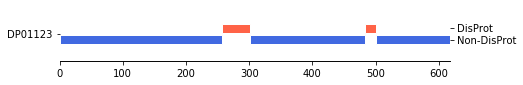

In [9]:
disprot_entry = 'DP01123'

def get_regs(sequence):
    statusdict = {0: 'order', 1: 'disorder', np.nan: 'undefined'}
    regions = list()
    for status, groups in groupby(enumerate(sequence), key=itemgetter(1)):
        groups = list(groups)
        start = groups[0][0]
        end = groups[-1][0]
        if not np.isnan(status):
            regions.append([start, end, end - start + 1, statusdict[status]])

    return regions

def plot_entry(disprot_entry, negs):
    regs = get_regs(refdict[disprot_entry]['states'])
    fig, ax = plt.subplots(figsize=(7, 1))
    ax.set_ylim(0.2, 0.8)
    ax.set_xlim(0, regs[-1][1])
    cmap = {'disorder': 'tomato', 'order': 'royalblue'}
    hmap = {'disorder': 0.56, 'order': 0.44}
    nmap = {'simple': 'Non-DisProt'}
    colors = list(map(cmap.get, list(zip(*regs))[-1]))
    heights = list(map(hmap.get, list(zip(*regs))[-1]))

    h = 0.1
    plt.barh(heights,
             list(zip(*regs))[2],
             left=list(zip(*regs))[0],
             height=h,
             color=colors,
             linewidth=1,
             edgecolor='w',
             label=list(zip(*regs))[-1])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    twy = ax.twinx()
    twy.spines['right'].set_visible(False)
    twy.spines['top'].set_visible(False)
    twy.spines['left'].set_visible(False)

    ax.set_yticks([0.5])
    ax.set_yticklabels([disprot_entry])
    twy.set_yticks([0.44 - h / 2, 0.56 + h / 2])
    twy.set_yticklabels([nmap.get(negs, negs.upper()), 'DisProt'])


negdefs = {'simple': "the contrary of DisProt"}
refdefs = {'new-disprot-all': "all its new entries"}

display(Markdown("""Current analysis is performed on the **{}** dataset with **{}** 
negative definition. This means that DisProt defines order for *{}* and *{} 
defines order*."""\
.format(reference, negatives, refdefs.get(reference, reference),
        negdefs.get(negatives, negatives))))
plot_entry(disprot_entry, negatives)

In [10]:
sentence = """DisProt merged regions define positive cases (labeled as $1$) in reference states. Remaining states are considered {}.""".format("negatives" if negatives == 'simple' else "undefined")

display(Markdown("""DisProt entries can have annotation covering the same sequence space. In these cases different evidences are merged in a unique continuous region. """ + sentence))

DisProt entries can have annotation covering the same sequence space. In these cases different evidences are merged in a unique continuous region. DisProt merged regions define positive cases (labeled as $1$) in reference states. Remaining states are considered negatives.

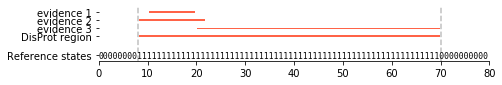

In [11]:
fig, ax = plt.subplots(figsize=(7, 1))
ax.set_ylim(-1.2, 0.8)
ax.set_xlim(0, 80)

ys = np.array([0.6, 0.3, 0.0, -0.3])
hs = np.array([.12, .12, .12, .14])
lbls = ['evidence 1', 'evidence 2', 'evidence 3', 'DisProt region']

ax.barh(ys, [10, 14, 50, 62], left=[10, 8, 20, 8], height=hs, linewidth=2, edgecolor='w', facecolor='tomato');

if negatives != 'simple':
    ax.barh(-0.6, 15, left=65, height=.12, facecolor='royalblue')
    ys = np.append(ys, -0.6)
    lbls.append(negatives)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.axvline(8, c='grey', alpha=0.5, linestyle='--')
ax.axvline(70, c='grey', alpha=0.5, linestyle='--')

neg_char = '0' if negatives == 'simple' else '-'
ax.text(0, -1, neg_char * 8 + '1' * 62 + '0' * 10, fontsize=8.1, 
        verticalalignment='center', family='monospace')
lbls.append('Reference states')

ax.set_yticks(np.append(ys, -1))
ax.set_yticklabels(lbls);

In [12]:
def get_pname(ref, negs, btype=None):
    """Build predictor name from parameters"""
    pname = [ref, negs]
    if btype is not None:
        pname.append(btype)
    return '_'.join(pname)


def get_fname(ref, negs, rdir, rtype, btype=None):
    """Get prediction filename from parameter"""
    ext = '.txt' if rtype in ('rocPoints', 'prcPoints') else '.csv'
    fname = [get_pname(ref, negs, btype), rtype]
    return os.path.join(rdir, '_'.join(fname) + ext)

In [13]:
def add_auc(df, ref, negs, rdir, curve, baseline=False):
    """Append AUC from a curve file to a DataFrame"""
    btype = 'cons' if baseline is True else None
    curvefile = get_fname(ref, negs, rdir,
                          'rocPoints' if curve is 'roc' else 'prcPoints',
                          btype)

    table = []
    if os.path.isfile(curvefile):
        for columns in parse_curve_file(curvefile):
            table.append(columns[:2])
    else:
        table.append([get_pname(ref, negs, btype), np.nan])

    return pd.concat([
        df,
        pd.DataFrame(table, columns=['pred', 'AUC-{}'.format(curve)
                                     ]).set_index(['pred'])
    ],
                     sort=False,
                     axis=1)

In [14]:
def load_scores_tables(ref, negs, base_dir, res_dir, optimized_thr):
    if optimized_thr != "Default":
        assert optimized_thr in {"ROC", 'Fmax'}
        stype = 'redefScores{}'.format(optimized_thr)
    else:
        stype = 'scores'

    # baselines
    bchunk = pd.read_csv(get_fname(ref, negs, base_dir, 'scores', 'chunk'),
                         index_col=[0]).mean().to_frame().transpose()
    bchain = pd.read_csv(get_fname(ref, negs, base_dir, 'scores', 'chain'),
                         index_col=[0]).mean().to_frame().transpose()
    bcons = pd.read_csv(get_fname(ref, negs, base_dir, stype, 'cons'),
                        index_col=[0]).mean().to_frame().transpose().rename(
                            index={0: get_pname(ref, negs, 'cons')})
    bln = [bchunk, bchain, bcons]
    bln_names = ['chunk', 'chain', 'cons']
    
    if negs:
        bnaifg = pd.read_csv(get_fname(ref, negs, base_dir, 'scores',
                                       'naive-new-gene3d-r_simple'),
                             index_col=[0]).mean().to_frame().transpose()
        bln += [bnaifg]
        bln_names += ['naive-gene3d']
    
    if negs:
        bnaifp = pd.read_csv(get_fname(ref, negs, base_dir, 'scores',
                                       'naive-new-pdb-r_simple'),
                             index_col=[0]).mean().to_frame().transpose()
        bln += [bnaifp]
        bln_names += ['naive-pdb']

    # predictions
    preds = pd.read_csv(get_fname(ref, negs, res_dir, stype), index_col=[0])

    # merge baselines
    base = pd.concat(bln, axis=0, sort=False)
    base.index = bln_names
    return base, preds

def merge_scores_tables(ref, negs, base_dir, res_dir, optimized_thr):
    """Merge all baselines and predictors' scores"""
    base, preds = load_scores_tables(ref,
                                     negs,
                                     base_dir,
                                     res_dir,
                                     optimized_thr=optimized_thr)
    # merge baselines and predictions
    df = pd.concat([preds, base], sort=False).round(3)
    df[["TP", "FN", "TN", "FP", "npred",
        "nref"]] = df[["TP", "FN", "TN", "FP", "npred", "nref"]].astype(int)
    return df

In [15]:
def load_target_tables(ref, negs, base_dir, res_dir, optimized_thr):
    if optimized_thr != "Default":
        assert optimized_thr in {"ROC", 'Fmax'}
        stype = 'redefScores{}'.format(optimized_thr)
    else:
        stype = 'scores'

    stype = 'perInstanceRedefScores' if optimized_thr is True else 'perInstanceScores'
    # baselines
    bchunk = pd.read_csv(get_fname(ref, negs, base_dir, 'perInstanceScores',
                                   'chunk'),
                         index_col=[0, 1],
                         header=[0]).groupby(level=1).mean()
    bchunk = bchunk.set_index([['random_chunk'] * len(bchunk), bchunk.index])

    bchain = pd.read_csv(get_fname(ref, negs, base_dir, 'perInstanceScores',
                                   'chain'),
                         index_col=[0, 1],
                         header=[0]).groupby(level=1).mean()
    bchain = bchain.set_index([['random_chain'] * len(bchain), bchain.index])

    bcons = pd.read_csv(get_fname(ref, negs, base_dir, stype, 'cons'),
                        index_col=[0, 1]).reset_index(level=0, drop=True)
    bcons = bcons.set_index([['cons'] * len(bcons), bcons.index])
    bln = [bchunk, bchain, bcons]

    if negs:# != 'gene3d':
        bnaifg = pd.read_csv(get_fname(ref, negs, base_dir,
                                       'perInstanceScores', 'naive-new-gene3d-r_simple'),
                             index_col=[0, 1]).reset_index(level=0, drop=True)
        bnaifg = bnaifg.set_index([['naive-gene3d'] * len(bnaifg),
                                   bnaifg.index])
        bln.append(bnaifg)

    if negs:# != 'pdb':
        bnaifp = pd.read_csv(get_fname(ref, negs, base_dir,
                                       'perInstanceScores', 'naive-new-pdb-r_simple'),
                             index_col=[0, 1]).reset_index(level=0, drop=True)
        bnaifp = bnaifp.set_index([['naive-pdb'] * len(bnaifp), bnaifp.index])
        bln.append(bnaifp)

    # predictions
    preds = pd.read_csv(get_fname(ref, negs, res_dir, stype),
                        index_col=[0, 1],
                        header=[0])
    # merge baselines
    base = pd.concat(bln, axis=0, sort=False)

    return base, preds


def merge_targets_tables(ref, negs, base_dir, res_dir, optimized_thr):
    """Merge all baselines and predictors' scores"""
    base, preds = load_target_tables(ref,
                                     negs,
                                     base_dir,
                                     res_dir,
                                     optimized_thr=optimized_thr)
    # merge all

    return pd.concat([preds, base], axis=0, sort=False).round(3)

In [16]:
def parse_curve_file(curve_file, parse_code=None):
    """Parse ROC and PRC files"""
    with open(curve_file) as f:
        for line in f:
            code, _, auc, *points = line.split()
            auc = float(auc)
            x, y, thr = zip(*map(lambda s: map(float, s.split(',')), points))

            if parse_code is not None and callable(parse_code):
                code = parse_code(code)

            yield code, auc, np.array(x), np.array(y), np.array(thr)


def merge_curves(curve_type):
    curve_type += 'Points'
    
    preds = list(
        parse_curve_file(
            get_fname(reference, negatives, results_dir, curve_type)))

    base_cons = list(
        parse_curve_file(
            get_fname(reference, negatives, baseline_dir, curve_type,
                      'cons'), lambda c: c.split('_')[-1]))
    base_naifg = list(
        parse_curve_file(
            get_fname(reference, negatives, baseline_dir, curve_type,
                      'naive-new-gene3d-r_simple')))
    base_naifp = list(
        parse_curve_file(
            get_fname(reference, negatives, baseline_dir, curve_type,
                      'naive-new-pdb-r_simple')))
    
    return preds, base_cons + base_naifg + base_naifp

In [17]:
def load_predstack(fname):
    with open(fname) as f:
        targets = {}
        preds = {}
        for line in f:
            line = line.strip()
            if line[0] == '#':
                target_positions = line[1:].split("#")
                for position in target_positions:
                    target, start, end = position.split(",")
                    targets[target] = (int(start), int(end))
            else:
                method, pred = line.split()
                preds[method] = np.fromiter(map(int, pred), dtype=np.float)

    return targets, preds


def merge_predstacks(fname):
    pass

In [77]:
# build score table (may take a while)
scores_base, scores_pred = load_scores_tables(reference, negatives, baseline_dir, results_dir, thr_optimization)
scores = merge_scores_tables(reference, negatives, baseline_dir, results_dir, thr_optimization)

In [59]:
# build target-wise score table
target_scores_base, target_scores_pred = load_target_tables(reference, negatives, baseline_dir,
                                                            results_dir, thr_optimization)

target_scores = merge_targets_tables(reference, negatives, baseline_dir,
                                     results_dir, thr_optimization)

In [20]:
rocs, rocs_base = merge_curves('roc')
prcs, prcs_base = merge_curves('prc')

## Evaluation metrics

In [21]:
sortby = "BAc"
display(
    Markdown("""
Metrics evaluating prediction scores are calculated applying **{}** thresholds to prediction scores.
Table is sorted by descending value of {} column
""".format(thr_optimization, sortby)))


Metrics evaluating prediction scores are calculated applying **Default** thresholds to prediction scores.
Table is sorted by descending value of BAc column


In [29]:
scores.sort_values(by="BAc", ascending=False).drop(["F1s_n", "Pre_n", "FPR"], axis=1).rename(index=labels_names)

,FN,FP,TN,TP,BAc,F1s,MCC,Pre,Rec,Rec_n,AUC_PRC,AUC_ROC,npred,nref
*SPOT-Disorder2,11513,70732,150676,36238,0.720,0.468,0.343,0.339,0.759,0.681,0.340,0.760,610,646
*RawMSA,17363,75205,206786,37241,0.708,0.446,0.325,0.331,0.682,0.733,0.414,0.780,646,646
*SPOT-Disorder1,13693,93968,187481,40600,0.707,0.430,0.311,0.302,0.748,0.666,0.268,0.744,644,646
*AUCpreD,17070,81154,193350,37485,0.696,0.433,0.303,0.316,0.687,0.704,0.479,0.757,644,646
Predisorder,10526,111932,156268,43971,0.695,0.418,0.292,0.282,0.807,0.583,0.325,0.747,642,646
IsUnstruct,13771,102404,179587,40833,0.692,0.413,0.287,0.285,0.748,0.637,0.323,0.744,646,646
IUPred-long,19362,78821,203098,35198,0.683,0.418,0.285,0.309,0.645,0.720,0.298,0.737,645,646
VSL2B,10059,127742,153707,44234,0.680,0.391,0.266,0.257,0.815,0.546,0.301,0.732,644,646
IUPred2A-long,19974,77265,204726,34630,0.680,0.416,0.282,0.309,0.634,0.726,0.298,0.735,646,646
fIDPln,27013,41412,240579,27505,0.679,0.446,0.327,0.399,0.505,0.853,0.422,0.793,645,646


Where table column names mean:

| label | meaning |
|---|---|
| BAc  | balanced accuracy  |
| F1s  | F1-score  |
| MCC  | Matthew's Correlation Coefficient  |
| Pre  | Precision/Selectivity  |
| Rec  | Recall/Sensitivity  |
| Rec_n  | Specificity  |
| AUC_ROC  | Area under the ROC curve  |
| AUC_PRC  | Area under the PR curve  |
| npred  | number of predicted targets  |
| nref  | number of targets in reference  |


### Balanced accuracy
Comparison of predictors and baselines performance by balanced accuracy.

In [23]:
# load base and predictors scores (per-residue)
b, p = load_scores_tables(reference, negatives, baseline_dir, results_dir,
                          thr_optimization)
# load base and predictors scores (per-target)
bt, pt = load_target_tables(reference, negatives, baseline_dir, results_dir,
                            thr_optimization)

/home/marnec/.local/share/virtualenvs/caid-ICjYQIts/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


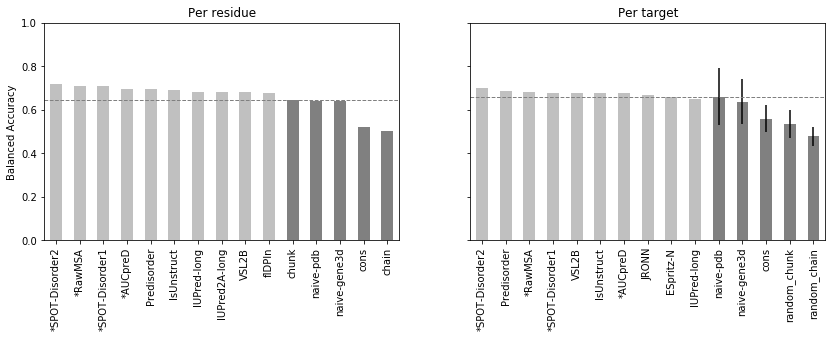

In [37]:
bt_acc_mean, bt_acc_std = bt.xs('bal_acc', level=1).mean(axis=1), bt.xs(
    'bal_acc', level=1).std(axis=1)
pt_acc_mean, pt_acc_std = pt.xs('bal_acc', level=1).mean(axis=1), pt.xs(
    'bal_acc', level=1).std(axis=1)

# init figure
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# plot style
p = p.sort_values(by="BAc", ascending=False).head(10).rename(index=labels_names) if style == "Slides" else p
pt_acc_mean = pt_acc_mean.sort_values(ascending=False).rename(index=labels_names).head(10) if style == "Slides" else pt_acc_mean

# set different colors for prediction and baselines
colors = ['silver'] * len(p) + ['grey'] * len(b)

# draw per-residue bars
p['BAc'].sort_values(ascending=False).append(
    b['BAc'].sort_values(ascending=False)).plot.bar(color=colors, ax=axes[0])

axes[0].set_ylabel('Balanced Accuracy')
axes[0].set_ylim(0, 1)
axes[0].set_title('Per residue')

# draw horizontal line at maximum baseline
axes[0].axhline(b['BAc'].max(), linestyle='--', color='grey', linewidth=1)

# draw mean per-target bars
acc_mean = pt_acc_mean.sort_values(ascending=False).append(
    bt_acc_mean.sort_values(ascending=False))

# order std with the same order as mean
acc_std = pt_acc_std.append(bt_acc_std).loc[acc_mean.index]

# plot bars with error
acc_mean.plot.bar(color=colors, ax=axes[1], yerr=acc_std / 2)

# draw horizontal line at maximum baseline
axes[1].axhline(bt_acc_mean.max(), linestyle='--', color='grey', linewidth=1)
axes[1].set_ylabel('Balanced Accuracy')
axes[1].set_title('Per target');

Overall (left panel) and average per-target (right panel) balanced accuracy. Light gray bars represent published prediction methods; dark gray bars represent baseline prediction methods. On the right panel standard deviation is shown as an error bar.

### F1-score
Comparison of predictors and baselines performance by F1-score.

/home/marnec/.local/share/virtualenvs/caid-ICjYQIts/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


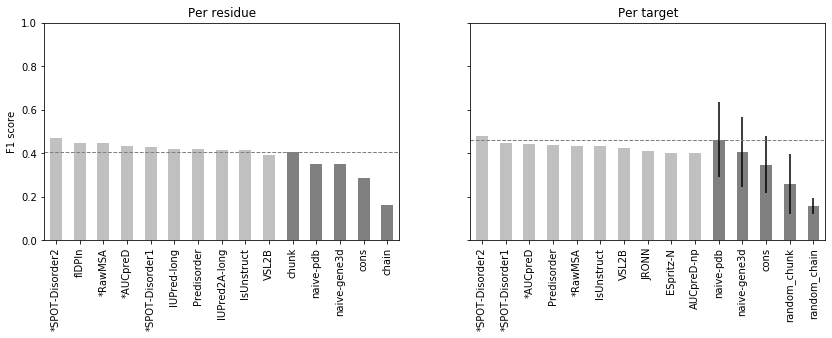

In [27]:
bt_f1s_mean, bt_f1s_std = bt.xs('fscore', level=1).mean(axis=1), bt.xs(
    'fscore', level=1).std(axis=1)
pt_f1s_mean, pt_f1s_std = pt.xs('fscore', level=1).mean(axis=1), pt.xs(
    'fscore', level=1).std(axis=1)

# init figure
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# plot style
p = p.sort_values(by="BAc", ascending=False).head(10).rename(index=labels_names) if style == "Slides" else p
pt_f1s_mean = pt_f1s_mean.sort_values(ascending=False).head(10).rename(index=labels_names) if style == "Slides" else pt_f1s_mean

# set different colors for prediction and baselines
colors = ['silver'] * len(p) + ['grey'] * len(b)

# draw per-residue bars
p['F1s'].sort_values(ascending=False).append(
    b['F1s'].sort_values(ascending=False)).plot.bar(color=colors, ax=axes[0])

axes[0].set_ylabel('F1 score')
axes[0].set_ylim(0, 1)
axes[0].set_title('Per residue')

# draw horizontal line at maximum baseline
axes[0].axhline(b['F1s'].max(), linestyle='--', color='grey', linewidth=1)

# draw mean per-target bars
f1s_mean = pt_f1s_mean.sort_values(ascending=False).append(
    bt_f1s_mean.sort_values(ascending=False))

# order std with the same order as mean
f1s_std = pt_f1s_std.append(bt_f1s_std).loc[f1s_mean.index]

# plot bars with error
f1s_mean.plot.bar(color=colors, ax=axes[1], yerr=f1s_std / 2)

# draw horizontal line at maximum baseline
axes[1].axhline(bt_f1s_mean.max(), linestyle='--', color='grey', linewidth=1)
axes[1].set_ylabel('F1 score')
axes[1].set_title('Per target');

Overall (left panel) and average per-target (right panel) F1-score. Light gray bars represent published prediction methods; dark gray bars represent baseline prediction methods. On the right panel standard deviation is shown as an error bar.

### MCC
Comparison of predictors and baselines performance by Matthew's Correlation Coefficient.

/home/marnec/.local/share/virtualenvs/caid-ICjYQIts/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


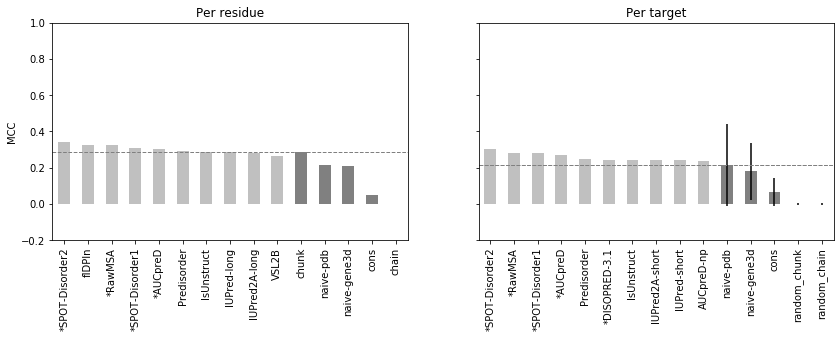

In [28]:
bt_mcc_mean, bt_mcc_std = bt.xs('mcc', level=1).mean(axis=1), bt.xs(
    'mcc', level=1).std(axis=1)
pt_mcc_mean, pt_mcc_std = pt.xs('mcc', level=1).mean(axis=1), pt.xs(
    'mcc', level=1).std(axis=1)
# init figure
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# plot style
p = p.sort_values(by="BAc", ascending=False).head(10).rename(index=labels_names) if style == "Slides" else p
pt_mcc_mean = pt_mcc_mean.sort_values(ascending=False).head(10).rename(index=labels_names) if style == "Slides" else pt_mcc_mean


# set different colors for prediction and baselines
colors = ['silver'] * len(p) + ['grey'] * len(b)
# draw per-residue bars
p['MCC'].sort_values(ascending=False).append(
    b['MCC'].sort_values(ascending=False)).plot.bar(color=colors, ax=axes[0])
axes[0].set_ylabel('MCC')
axes[0].set_ylim(-.2, 1)
axes[0].set_title('Per residue')
# draw horizontal line at maximum baseline
axes[0].axhline(b['MCC'].max(), linestyle='--', color='grey', linewidth=1)
# draw mean per-target bars
mcc_mean = pt_mcc_mean.sort_values(ascending=False).append(
    bt_mcc_mean.sort_values(ascending=False))
# order std with the same order as mean
mcc_std = pt_mcc_std.append(bt_mcc_std).loc[mcc_mean.index]
# plot bars with error
mcc_mean.plot.bar(color=colors, ax=axes[1], yerr=mcc_std / 2)
# draw horizontal line at maximum baseline
axes[1].axhline(bt_mcc_mean.max(), linestyle='--', color='grey', linewidth=1)
axes[1].axhline(bt_mcc_mean.max(), linestyle='--', color='grey', linewidth=1)
axes[1].set_title('Per target');

Overall (left panel) and average per-target (right panel) MCC. Light gray bars represent published prediction methods; dark gray bars represent baseline prediction methods. On the right panel standard deviation is shown as an error bar.

### Per target accuracy
Balanced accuracy score for each target for each prediction methods (including baslines)

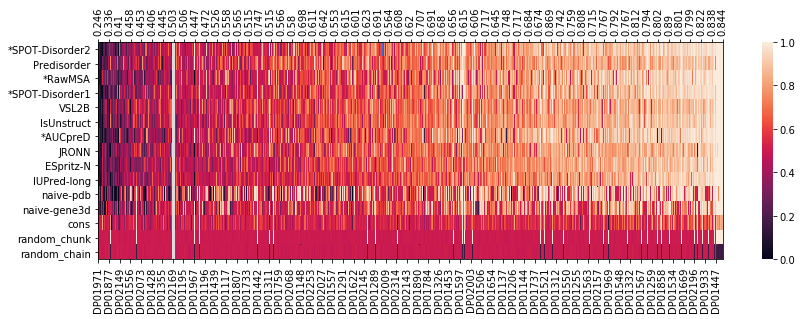

In [62]:
metric = 'bal_acc'
threshold = 0.5


if style == 'Slides':
    target_heatmap_preds = target_scores_pred.xs(metric, level=1).reindex(target_scores_pred.xs(
        metric, level=1).mean().sort_values().index, axis=1).loc[target_scores_pred.xs(
        metric, level=1).mean(axis=1).sort_values(ascending=False).index].rename(index=labels_names).head(10)
    
#     target_heatmap_preds = target_heatmap_preds.loc[target_scores_pred.xs(
#         metric, level=1).mean(axis=1).sort_values(ascending=False).index].head(10).rename(index=labels_names)
    
    target_heatmap_base = target_scores_base.xs(metric, level=1).reindex(target_scores_base.xs(
        metric, level=1).mean().sort_values().index, axis=1).loc[target_scores_base.xs(
        metric, level=1).mean(axis=1).sort_values(ascending=False).index]
    
    target_heatmap = pd.concat([target_heatmap_preds,target_heatmap_base], sort=False)

else:
    # sort columns by column average
    target_heatmap = target_scores.xs(metric, level=1).reindex(target_scores.xs(
        metric, level=1).mean().sort_values().index, axis=1)

    # sort rows by row average
    target_heatmap = target_heatmap.loc[target_scores.xs(
        metric, level=1).mean(axis=1).sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(14, 4))
ax = sns.heatmap(target_heatmap.rename(index=labels_names), ax=ax)
ax.axes.get_yaxis().get_label().set_visible(False)
ax.set_facecolor('royalblue')

def find_nearest(array, value):
    array = np.fromiter(array, dtype=float)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

ax2 = ax.twiny()
ax2tick_location = ax.xaxis.get_ticklocs()

ax2tick_lbls = [
    target_heatmap.mean().values[list(target_heatmap.columns).index(
        l.get_text())] for l in ax.xaxis.get_ticklabels()
]

ax2.set_xticks(ax2tick_location)
ax2.set_xticklabels(np.array(ax2tick_lbls).round(3))
thr_x = dict(zip(map(float, ax2tick_lbls), ax2tick_location)).get(
    find_nearest(map(float, ax2tick_lbls), threshold))
ax.axvline(thr_x, linewidth=3, color='gainsboro')
ax2.tick_params(axis='x', rotation=90)

Heatmap of the predictors accuracy for each target. The higher the accuracy the lighter the color. Non-predicted targets are shown in blue. $x$ and $y$ axes are sorted by average accuracy over rows and columns respectively. A white semi-transparent vertical line marks the point where the average accuracy scores for a target is below (left) or above (right) $0.5$. Accuracy score approaches $0.5$ for a random classifier. Accuracy $< 0.5$ indicates anti-correlation between predicted and reference classes. Targets with an average accuracy score $<0.5$ are:

In [63]:
low_acc_targets = target_heatmap.mean()[target_heatmap.mean() <= 0.5].to_frame()

for i, t in enumerate(low_acc_targets.index, 1):
    sep = '\t'
    if i % 6 == 0:
        sep = '\n'
    print(t + sep, end='')

DP01971	DP01870	DP02010	DP01898	DP01278	DP01432
DP01281	DP01456	DP01128	DP01427	DP01130	DP01877
DP01494	DP01512	DP02334	DP01501	DP01203	DP01584
DP01145	DP01498	DP01462	DP01248	DP02149	DP01124
DP01844	DP01366	DP01141	DP01907	DP01407	DP01316
DP01724	DP01139	DP01883	DP01556	DP01285	DP02234
DP01474	DP01925	DP01185	DP02328	DP01878	DP01590
DP02073	DP01163	DP02324	DP02231	DP01774	DP01280
DP01978	DP01500	DP01477	DP01647	DP01428	DP01504
DP01612	DP01999	DP01772	DP01134	DP01551	DP01505
DP02086	DP01503	DP01355	DP01600	DP01309	DP01324
DP02247	DP01313	DP02168	DP01323	DP01499	DP01434
DP01749	DP01172	DP01430	DP01252	DP01887	DP02296
DP01528	DP01396	DP01914	DP01150	DP01364	DP01473
DP02326	DP01869	DP01967	DP02025	DP01489	DP01854
DP01110	DP01196	DP01762	DP01177	DP01187	DP01437
DP01339	DP01580	DP02001	DP01351	DP02301	DP01658


###  Target correlation matrix

Commonly, experimental data has a bias for low disorder-content. DisProt targets have high disorder-content. Classifiers have been trained/engineered on low disorder-content. I expect difficult targets to have high disorder content. To verify is there is any correlation between target features I'm plotting 4 selected features against each other (Balanced accuracy, F1-Score, Sequence length and ID content). A fifth feature (ID position) divides the datasets in subsets. ID position is calculated as the average of the indexes of disordered residues along the sequence. A correlation is observed in a subset if its points gather around a diagonal.

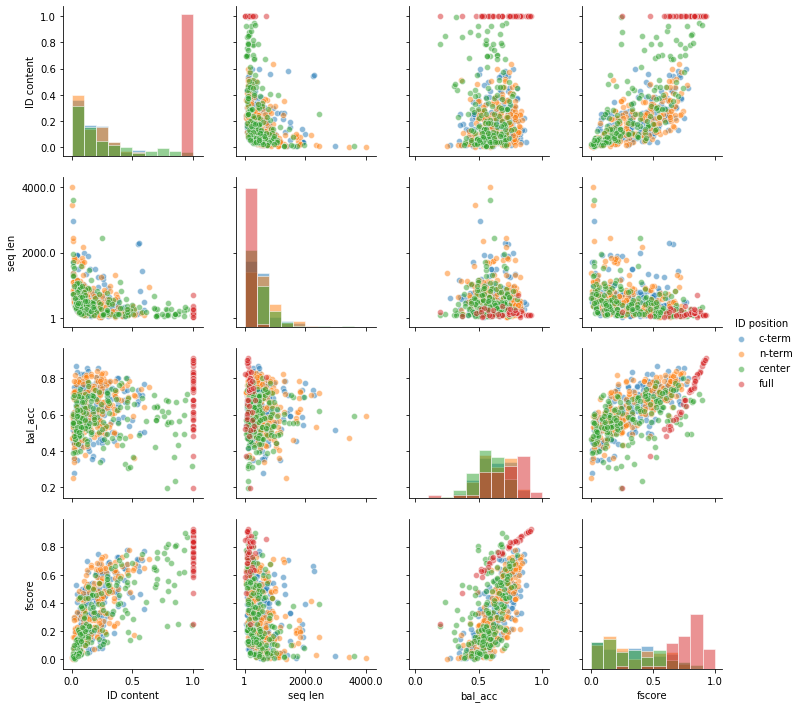

In [65]:
def avg_id_pos(s):
    s = s[~np.isnan(s)]
    p = np.argwhere(s == np.amax(s)).flatten() / s.size
    if np.unique(s).size == 1:
        pos = 'full' if np.mean(s) == 1 else 'none'
    else:
        p = np.mean(p)
        if p < 0.33:
            pos = 'n-term'
        elif 0.33 <= p <= 0.66:
            pos = 'center'
        else:
            pos = 'c-term'
    return pos


# get per-target scores averaged over methods
target_avg_scores = target_scores.mean(level=1).transpose()
# calculate disorder content from loaded reference
id_content = pd.DataFrame([[p, np.nanmean(refdict[p]['states'])]
                           for p in refdict
                           ]).set_index([0]).rename(columns={1: 'ID content'})
# calculate protein length from loaded reference
p_len = pd.DataFrame([[p, len(refdict[p]['seq'])] for p in refdict
                      ]).set_index([0]).rename(columns={1: 'seq len'})
# rescale length in range (0, 1) --> I can set range=(0, 1) when drawing
maxlen = p_len.max().max()
p_len = p_len / maxlen
# calculate average position of disorder in disprot entry
pos = pd.DataFrame([(p, avg_id_pos(refdict[p]['states'])) for p in refdict
                    ]).set_index([0]).rename(columns={1: 'ID position'})
# concatenate everything
corr = pd.concat([id_content, target_avg_scores, p_len, pos],
                 axis=1,
                 sort=False)

# draw correlation matrix for selected columns
v = ["ID content", "seq len", "bal_acc", "fscore"]
g = sns.pairplot(
    corr,
    vars=v,
    hue="ID position",
    diag_kind="hist",
    plot_kws={'alpha': 0.5},  # set transparency of dots
    diag_kws={
        'alpha': 0.5,  # set transparency of hist bars
        'edgecolor': 'w',  # set edge color of hist bars
        'bins': 10,
        'range': (0, 1),  # make all bins boundaries equal
        'density': True,
    })  # rescale y axis in range (0, 1)

# redraw x-ticks of seq len for its actual scale
vi = v.index("seq len")
maxlen = round(maxlen /
               (10**int(math.log10(maxlen)))) * (10**int(math.log10(maxlen)))
g.axes[vi, vi].set_xticks([0, 0.5, 1], minor=False)
g.axes[vi, vi].set_xticklabels([1, maxlen / 2, maxlen])
g.axes[vi, vi].set_yticks([0, 0.5, 1], minor=False)
g.axes[vi, vi].set_yticklabels([1, maxlen / 2, maxlen]);

Correlation matrix of Balanced accuracy, F1-Score, Sequence length and ID content. Average position of disorder is color-coded. Figure matrix is symmetrical. Plots along diagonal axis display single variables distributions. No meaningful correlation is observed.

### ROC curve
Receiver Operator Characteristic plot for predictors and baselines

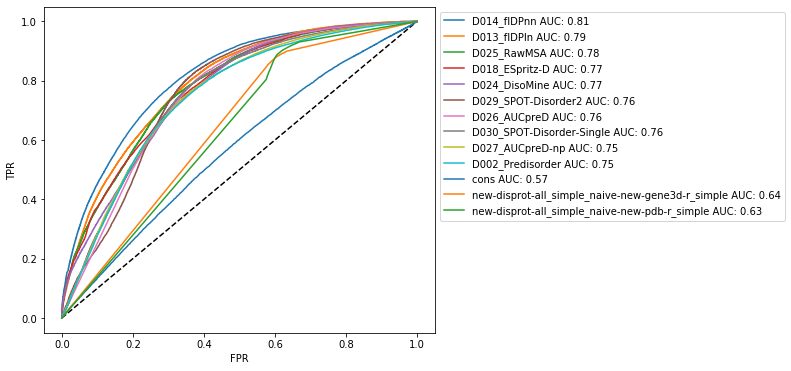

In [66]:
# # initialize a figure and an ax
fig, ax = plt.subplots(figsize=(7, 6))
# # plot diagonal
ax.plot([0, 1], [0, 1], linestyle='--', color='k')

# plot all curves in evaluation file
for curve_data in sorted(rocs, key=lambda d: d[1],
                         reverse=True)[:10] + rocs_base:
    code, auc_roc, x, y, thr = curve_data
    ax.plot(x, y, label='{} AUC: {:.2f}'.format(code, auc_roc))

ax.legend(bbox_to_anchor=(1, 1), loc=2)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR');

False Positive Rate (FPR) on $x$ axis, True Positive Rate (TPR) on $y$ axis. Methods are sorted by their Area Under the Curve (AUC). Only first ten methods plus baselines are shown.

### PR curve
Precision Recall curve plot for predictors and baselines

/home/marnec/.local/share/virtualenvs/caid-ICjYQIts/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


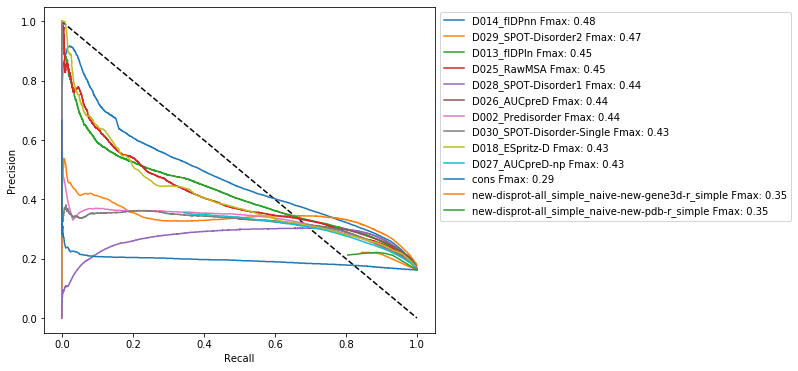

In [67]:
# # initialize a figure and an ax
fig, ax = plt.subplots(figsize=(7, 6))
# # plot diagonal
ax.plot([0, 1], [1, 0], linestyle='--', color='k')

aucf = lambda d: d[1]
fmaxf = lambda d: np.nanmax(2 *d[2]*d[3] / (d[2]+d[3]))
apsf = lambda d: np.sum((d[2] - np.concatenate([[0], d[2][:-1]])) * d[3])

# plot all curves in evaluation file
for curve_data in sorted(prcs, key=fmaxf, reverse=True)[:10] + prcs_base:
    code, auc_score, x, y, thr = curve_data
    aps = apsf(curve_data)
    fmax = fmaxf(curve_data)
        
    ax.plot(x, y, label='{} Fmax: {:.2f}'.format(code, fmax))

ax.legend(bbox_to_anchor=(1, 1), loc=2)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision');

Recall/Sensitivity on $x$ axis, Precision/Selectivity on $y$ axis. Methods are sorted by their Fmax. Only first ten methods plus baselines are shown.

In [68]:
def filter_rescale(data, rrange):
    rescaled = []
    for code, aucs, x, y, thr in data:
        filt = np.where((rrange[0] <= x) & (x <= rrange[1]))
        auc_score = metrics.auc(x[filt], y[filt]) / (rrange[1] - rrange[0])
        rescaled.append([code, auc_score])
    return rescaled

### pROC/pPR scatter plot
Plot of the AUCs from the ROC curve and PR curve

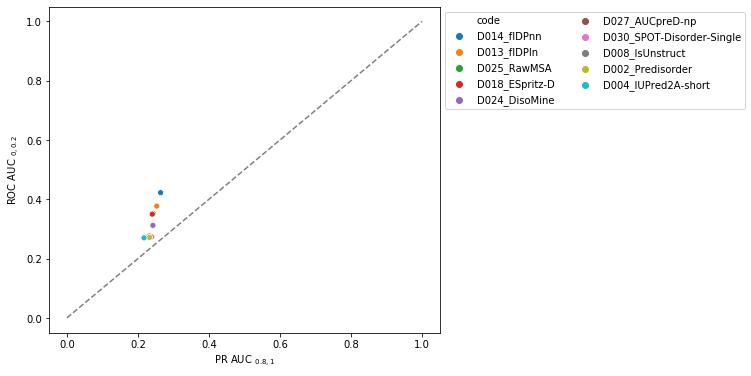

In [76]:
x = pd.DataFrame(filter_rescale(prcs + [prcs_base[0]], (0.8, 1)),
                 columns=['code', 'AUC PR']).set_index('code')
y = pd.DataFrame(filter_rescale(rocs + [rocs_base[0]], (0, 0.2)),
                 columns=['code', 'AUC ROC']).set_index('code')
data = pd.concat([x, y], axis=1).reset_index()

fig, ax = plt.subplots(figsize=(7, 6))

data = data.sort_values(by='AUC ROC', ascending=False)

if style == "Slides":
    data = data.head(10)

ax = sns.scatterplot(data=data,
                     x='AUC PR',
                     y='AUC ROC',
                     hue='code',
                     ax=ax)

ax.legend(bbox_to_anchor=(1, 1), ncol=2, loc=2)
ax.set_xlabel("PR AUC $_{0.8, 1}$")
ax.set_ylabel("ROC AUC $_{0, 0.2}$")
ax.plot((0, 1), (0, 1), linestyle='--', color='grey');

ROC AUC on the $x$ axis, Precision-Recall (PR) AUC on the $y$ axis. ROC AUC is calculated including ROC curve points with $x$ values (FPR) between 0 and 0.2. PR AUC is calculated including PR curve points with $x$ values (Recall) between 0.8 and 1. Both AUCs are then rescaled to the \[0, 1\] range.

### Average overall ranking
Predictor ranking and ranking statistical significance. Predictors are ranked on average rank from metrics scores: Balanced Accuracy, MCC, Precision, Recall, F1-score, F1-scores on negatives, Precision on negatives, Specificty, ROC AUC, PR AUC.

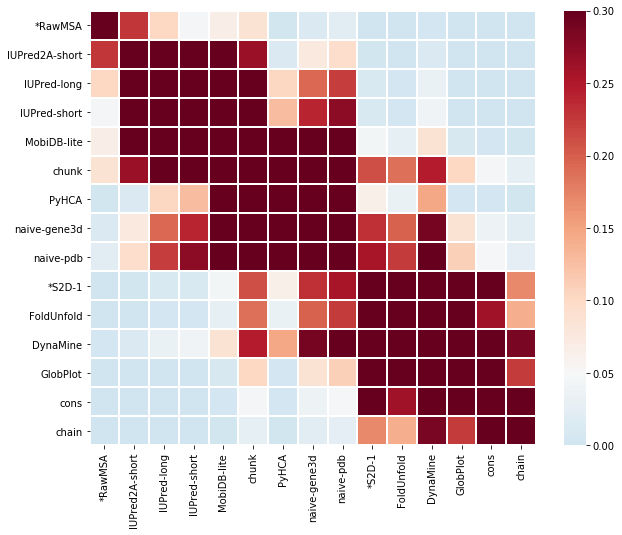

In [85]:
metrics = ['BAc', 'MCC', 'Pre', 'Rec', 'F1s', 'F1s_n', 'Pre_n', 'Rec_n', 'AUC_ROC', 'AUC_PRC']

if style == "Slides":
    spi = scores_pred[metrics].rank(axis=0, method='max', ascending=False, na_option='bottom').head(10).index
    sbi = scores_base[metrics].rank(axis=0, method='max', ascending=False, na_option='bottom').index
    mm = scores[metrics].loc[list(spi) + list(sbi)].rank(axis=0, method='max', ascending=False, na_option='bottom').rename(index=labels_names)

else:
    mm = scores[metrics].rank(axis=0, method='max', ascending=False, na_option='bottom')

coverage = scores['npred'] / scores['nref']

indcol = mm.apply(np.mean, axis=1).sort_values()
dff = pd.DataFrame(index=indcol.index, columns=indcol.index, dtype=float)
del dff.index.name

for indx, rowx in sorted(mm.iterrows(),
                         key=lambda r: r[1].mean(),
                         reverse=True):
    for indy, rowy in sorted(mm.iterrows(),
                             key=lambda r: r[1].mean(),
                             reverse=True):
        dff.loc[indx][indy] = float(ttest_ind(rowx, rowy).pvalue)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(dff,
            cmap='RdBu_r',
            annot=False,
            linecolor='w',
            linewidth=1,
            xticklabels=True,
            yticklabels=True,
            ax=ax,
            annot_kws={'size': 9},
            fmt='.2f',
            cbar=True,
            center=0.05,
            vmin=0,
            vmax=0.3)

# ax2 = ax.twiny()
# ax2.spines['right'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax2.spines['bottom'].set_visible(False)
# ax2.spines['left'].set_visible(False)

# lbls = ax.get_yticklabels()
# ax2.set_xticks(ax.get_xticks())
# ax2.set_xticklabels(coverage[list(map(lambda t: t.get_text(), lbls))].values.round(3))

plt.yticks(rotation=0)
plt.xticks(rotation=90);

Heatmap of the p-value associated to the statistical significance of the difference between ranking distributions. Coloramap is centered on $0.05$ so that any pvalue above $0.05$ is **red**-ish. Red color indicates that the ranking difference between two predictors is not statistically significant. Top tick labels of $x$ axis display prediction coverage for each predictor.

### Accuracy correlation between datasets
Per target average balanced accuracy correlation between *simple* and *pdb* negative definition. Datasets is divided by average disorder position in targets.

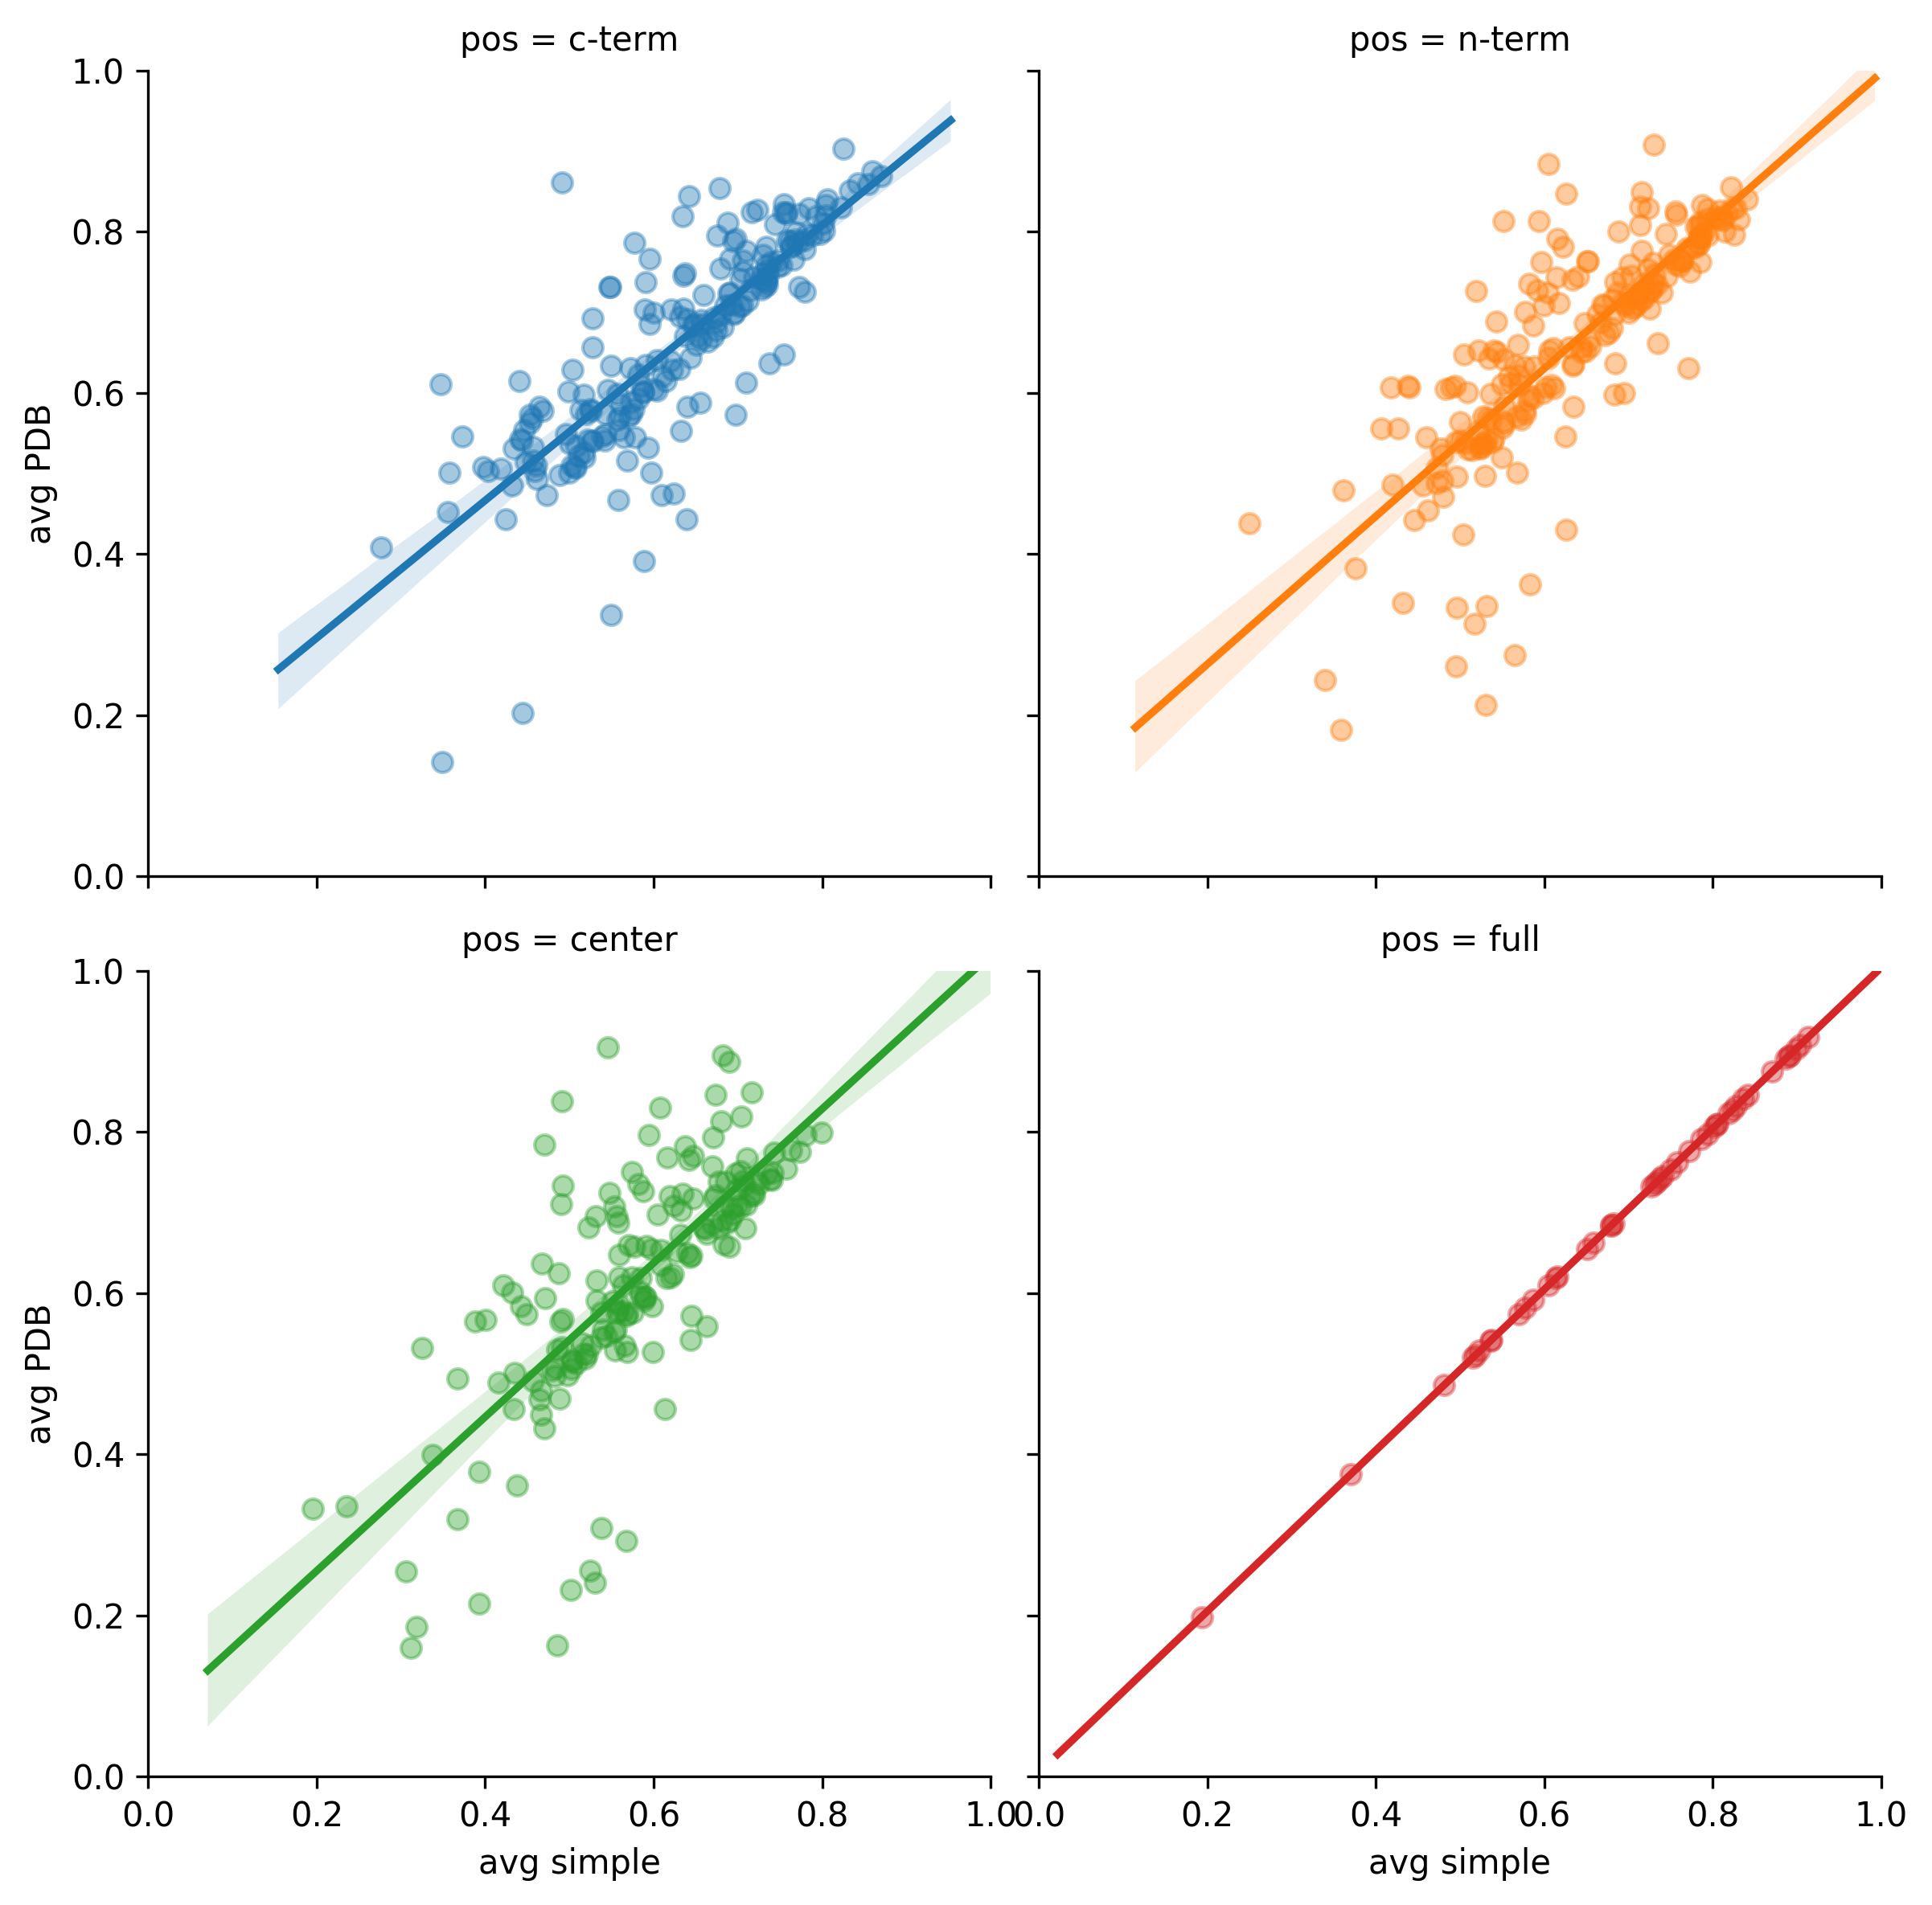

In [36]:
avg_acc = target_scores.xs('bal_acc', level=1)
t = pd.concat([avg_acc.mean(axis=0), avg_acc.std(axis=0)], axis=1,
              sort=False).rename(columns={
                  0: 'avg {}'.format(negatives),
                  1: 'std {}'.format(negatives)
              })

negs2 = 'pdb'
target_scores2 = merge_targets_tables(reference, negs2, baseline_dir,
                                      results_dir, thr_optimization)
avg_acc2 = target_scores2.xs('bal_acc', level=1)
t2 = pd.concat(
    [avg_acc2.mean(axis=0), avg_acc2.std(axis=0)], axis=1,
    sort=False).rename(columns={
        0: 'avg {}'.format(negs2.upper()),
        1: 'std {}'.format(negs2.upper())
    })

tt = pd.concat([t, t2], axis=1, sort=False)
tt['pos'] = pos

g = sns.lmplot(data=tt,
               x='avg {}'.format(negatives),
               y='avg {}'.format(negs2.upper()),
               hue='pos',
               col='pos',
               col_wrap=2,
               height=4,
               scatter_kws=dict(alpha=0.4))
g.set(ylim=(0, 1))
g.set(xlim=(0, 1));

Average balanced accuracy for targets with reference negative defined by the *simple* rule on $x$ axis. Average balanced accuracy for targets with reference negative defined by the *pdb* rule on $y$ axis. Each panel includes only targets with a specific average disorder position (C-terminal, N-Terminal, central, full-disorder)

## Consensus 
Consensus among all prediction methods was calculated as the fraction of positive predictions per residue.

In [37]:
consensus = pd.read_csv(get_fname(reference, negatives, results_dir,
                                  'consensusCM'),
                        index_col=[0])
consensus_cm = consensus[consensus.columns] / consensus.iloc[1].sum().round(
    2) * 100
consensus_cm[['tn', 'fp']] *= -1

consensus['fpr'] = consensus['fp'] / (consensus['fp'] + consensus['tn'])
consensus['tpr'] = consensus['tp'] / (consensus['tp'] + consensus['fn'])
consensus['fnr'] = 1 - consensus['tpr']
consensus['tnr'] = 1 - consensus['fpr']

minfpr = consensus['fpr'][consensus['fpr'] < 0.05].sort_values().tail(1)
minfpr_idx, minfpr_value = minfpr.index.item(), minfpr.item()
minfnr = consensus['fnr'][consensus['fnr'] < 0.05].sort_values().tail(1)
minfnr_idx, minfnr_value = minfnr.index.item(), minfnr.item()

### Confusion matrix per threshold
Predicted and actual positive and negatives for each threshold on the consensus score.

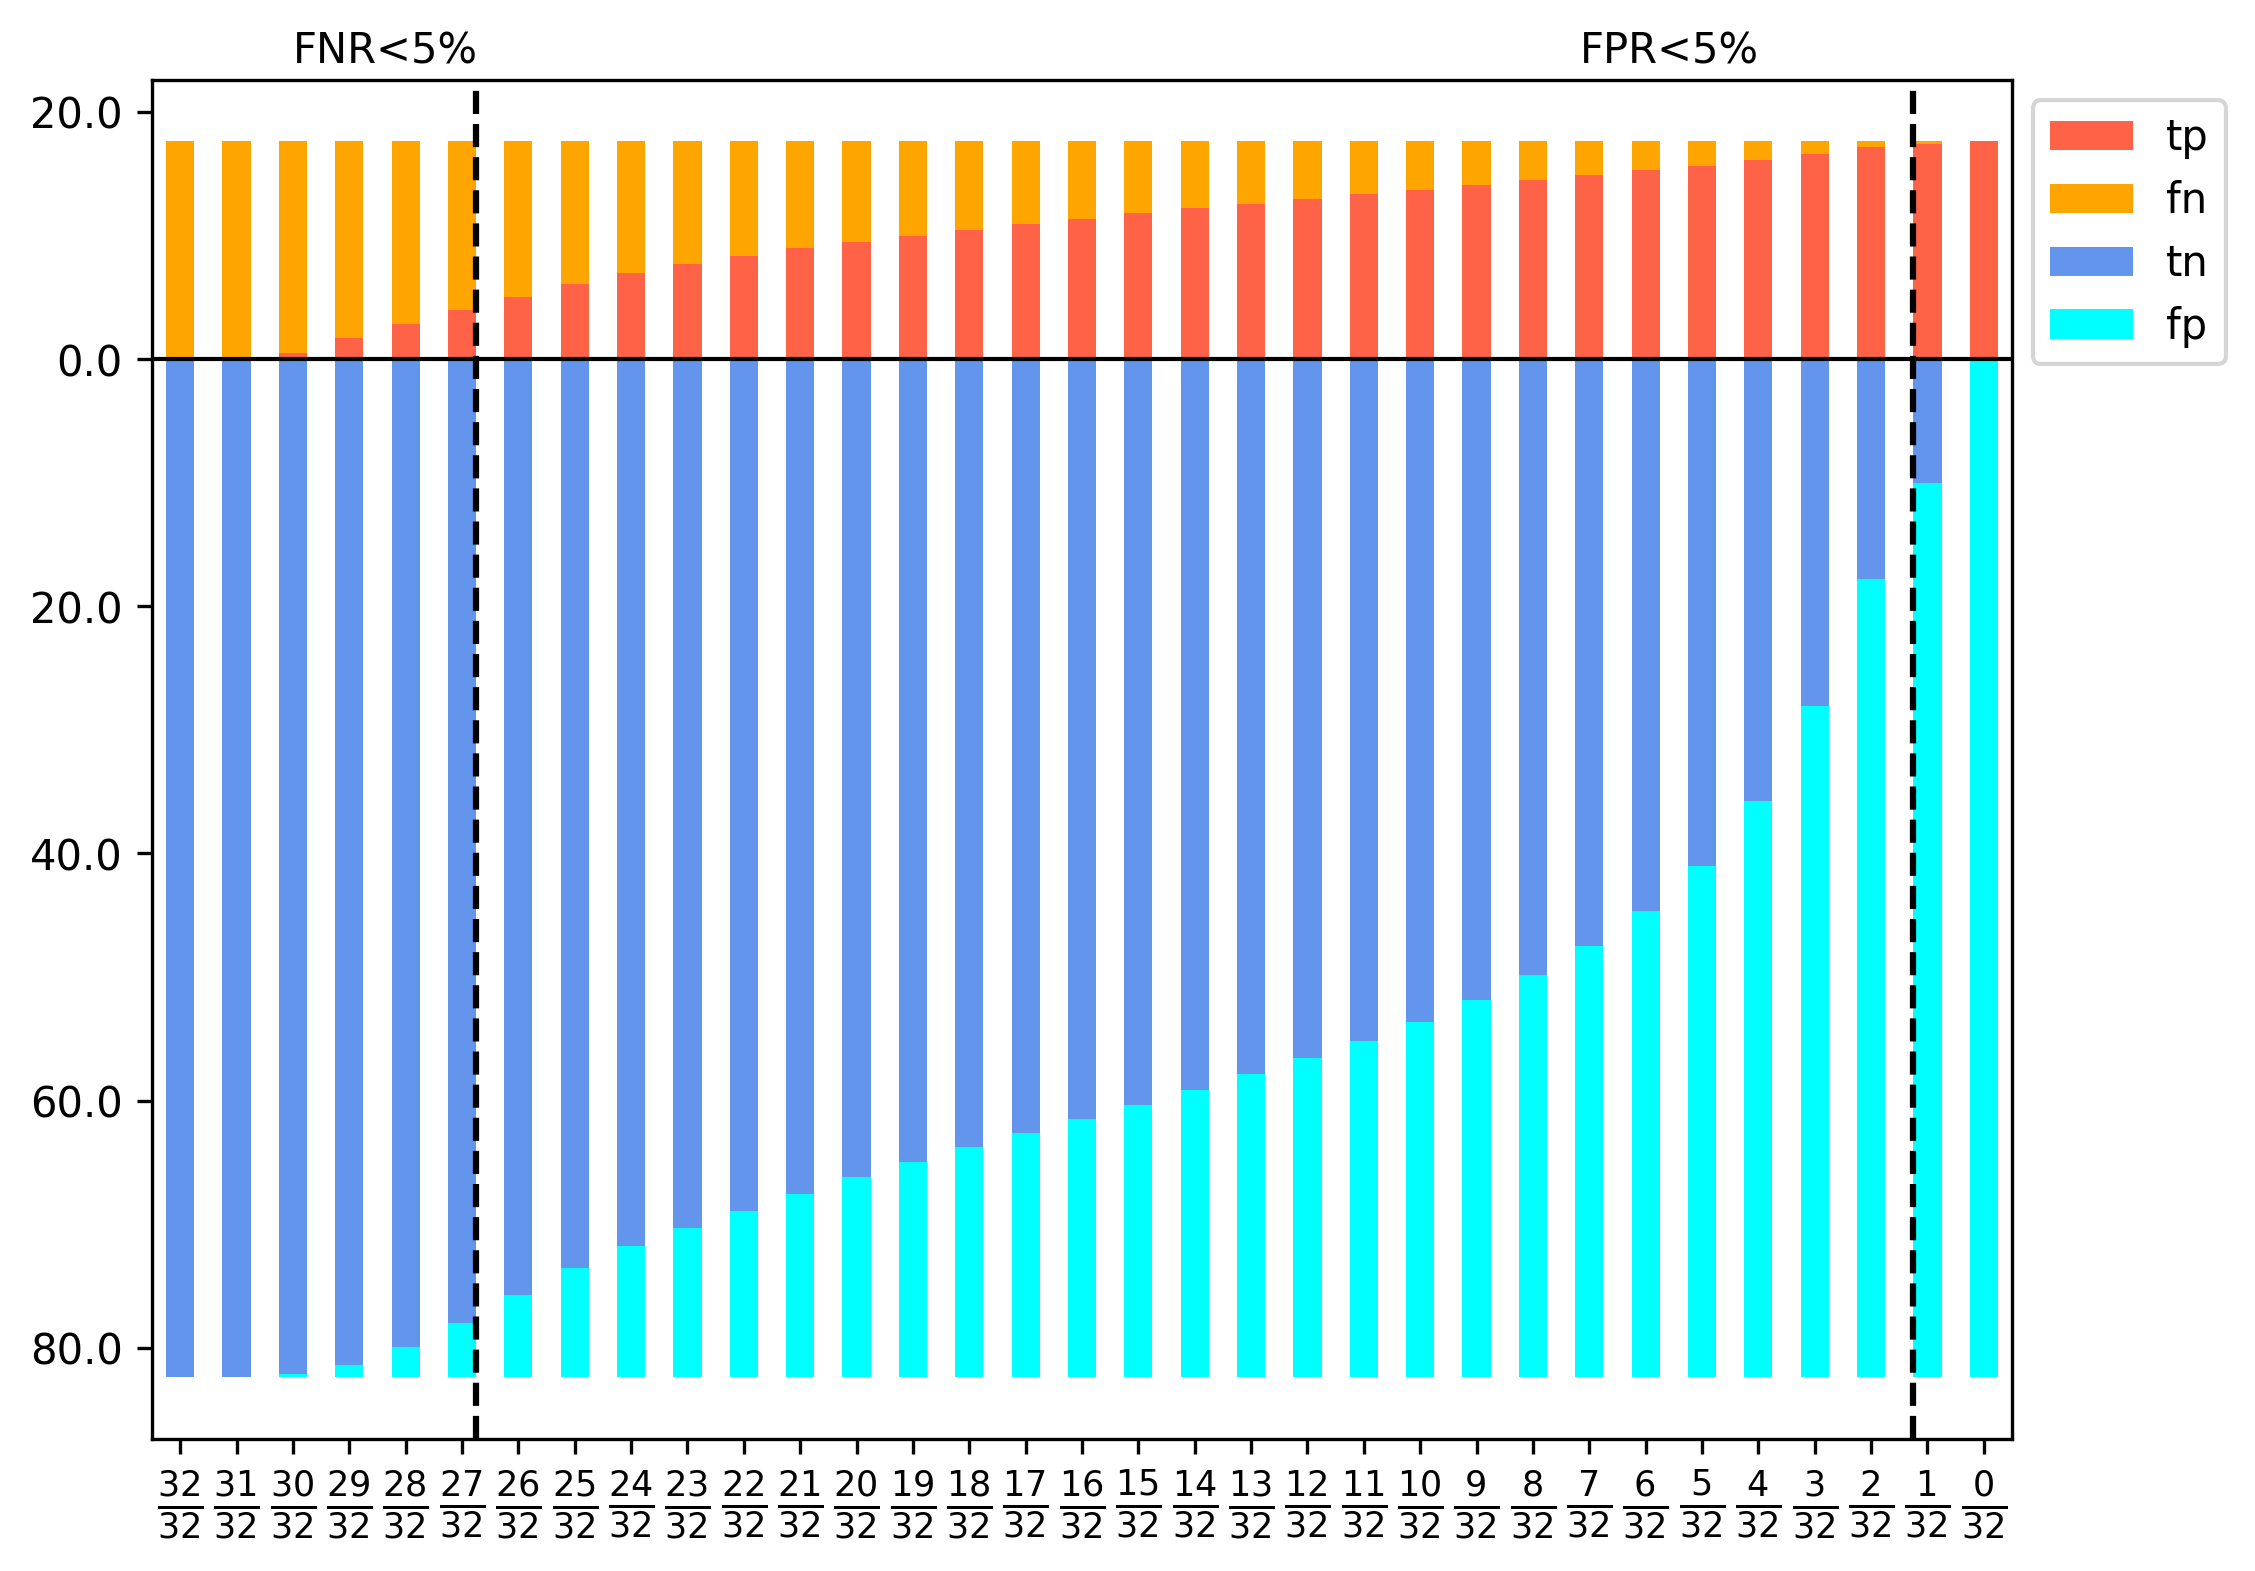

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

ax = consensus_cm[['tp', 'fn', 'tn',
                   'fp']].sort_index(ascending=False).plot.bar(
                       stacked=True,
                       ax=ax,
                       color=['tomato', 'orange', 'cornflowerblue', 'cyan'])

ax.set_yticklabels(map(abs, ax.get_yticks()))
ax.set_xticklabels([
    r'$\frac{{{}}}{{{}}}$'.format(l.get_text(),
                                  len(consensus_cm) - 1)
    for l in ax.get_xticklabels()
])
ax.tick_params(axis='x', which='both', rotation=0, labelsize=12)
ax.axhline(0, c='k', linewidth=1)

topplot = round(ax.get_ylim()[-1]) + 1
ax.axvline(len(consensus) - minfpr_idx + 0.25,
           linestyle='--',
           linewidth=1.5,
           c='k')
ax.axvline(len(consensus) - minfnr_idx - 0.25,
           linestyle='--',
           linewidth=1.5,
           c='k')
ax.text(minfpr_idx, topplot, 'FPR<5%', horizontalalignment='right')
ax.text(minfnr_idx, topplot, 'FNR<5%')
ax.legend(bbox_to_anchor=(1, 1));

Percentage of correct and wrong assignment of positives (above $0$) and negatives (below $0$) for each threshold of the consensus.

### Accuracy per threshold
Balanced accuracy score for each threshold of the consensus.

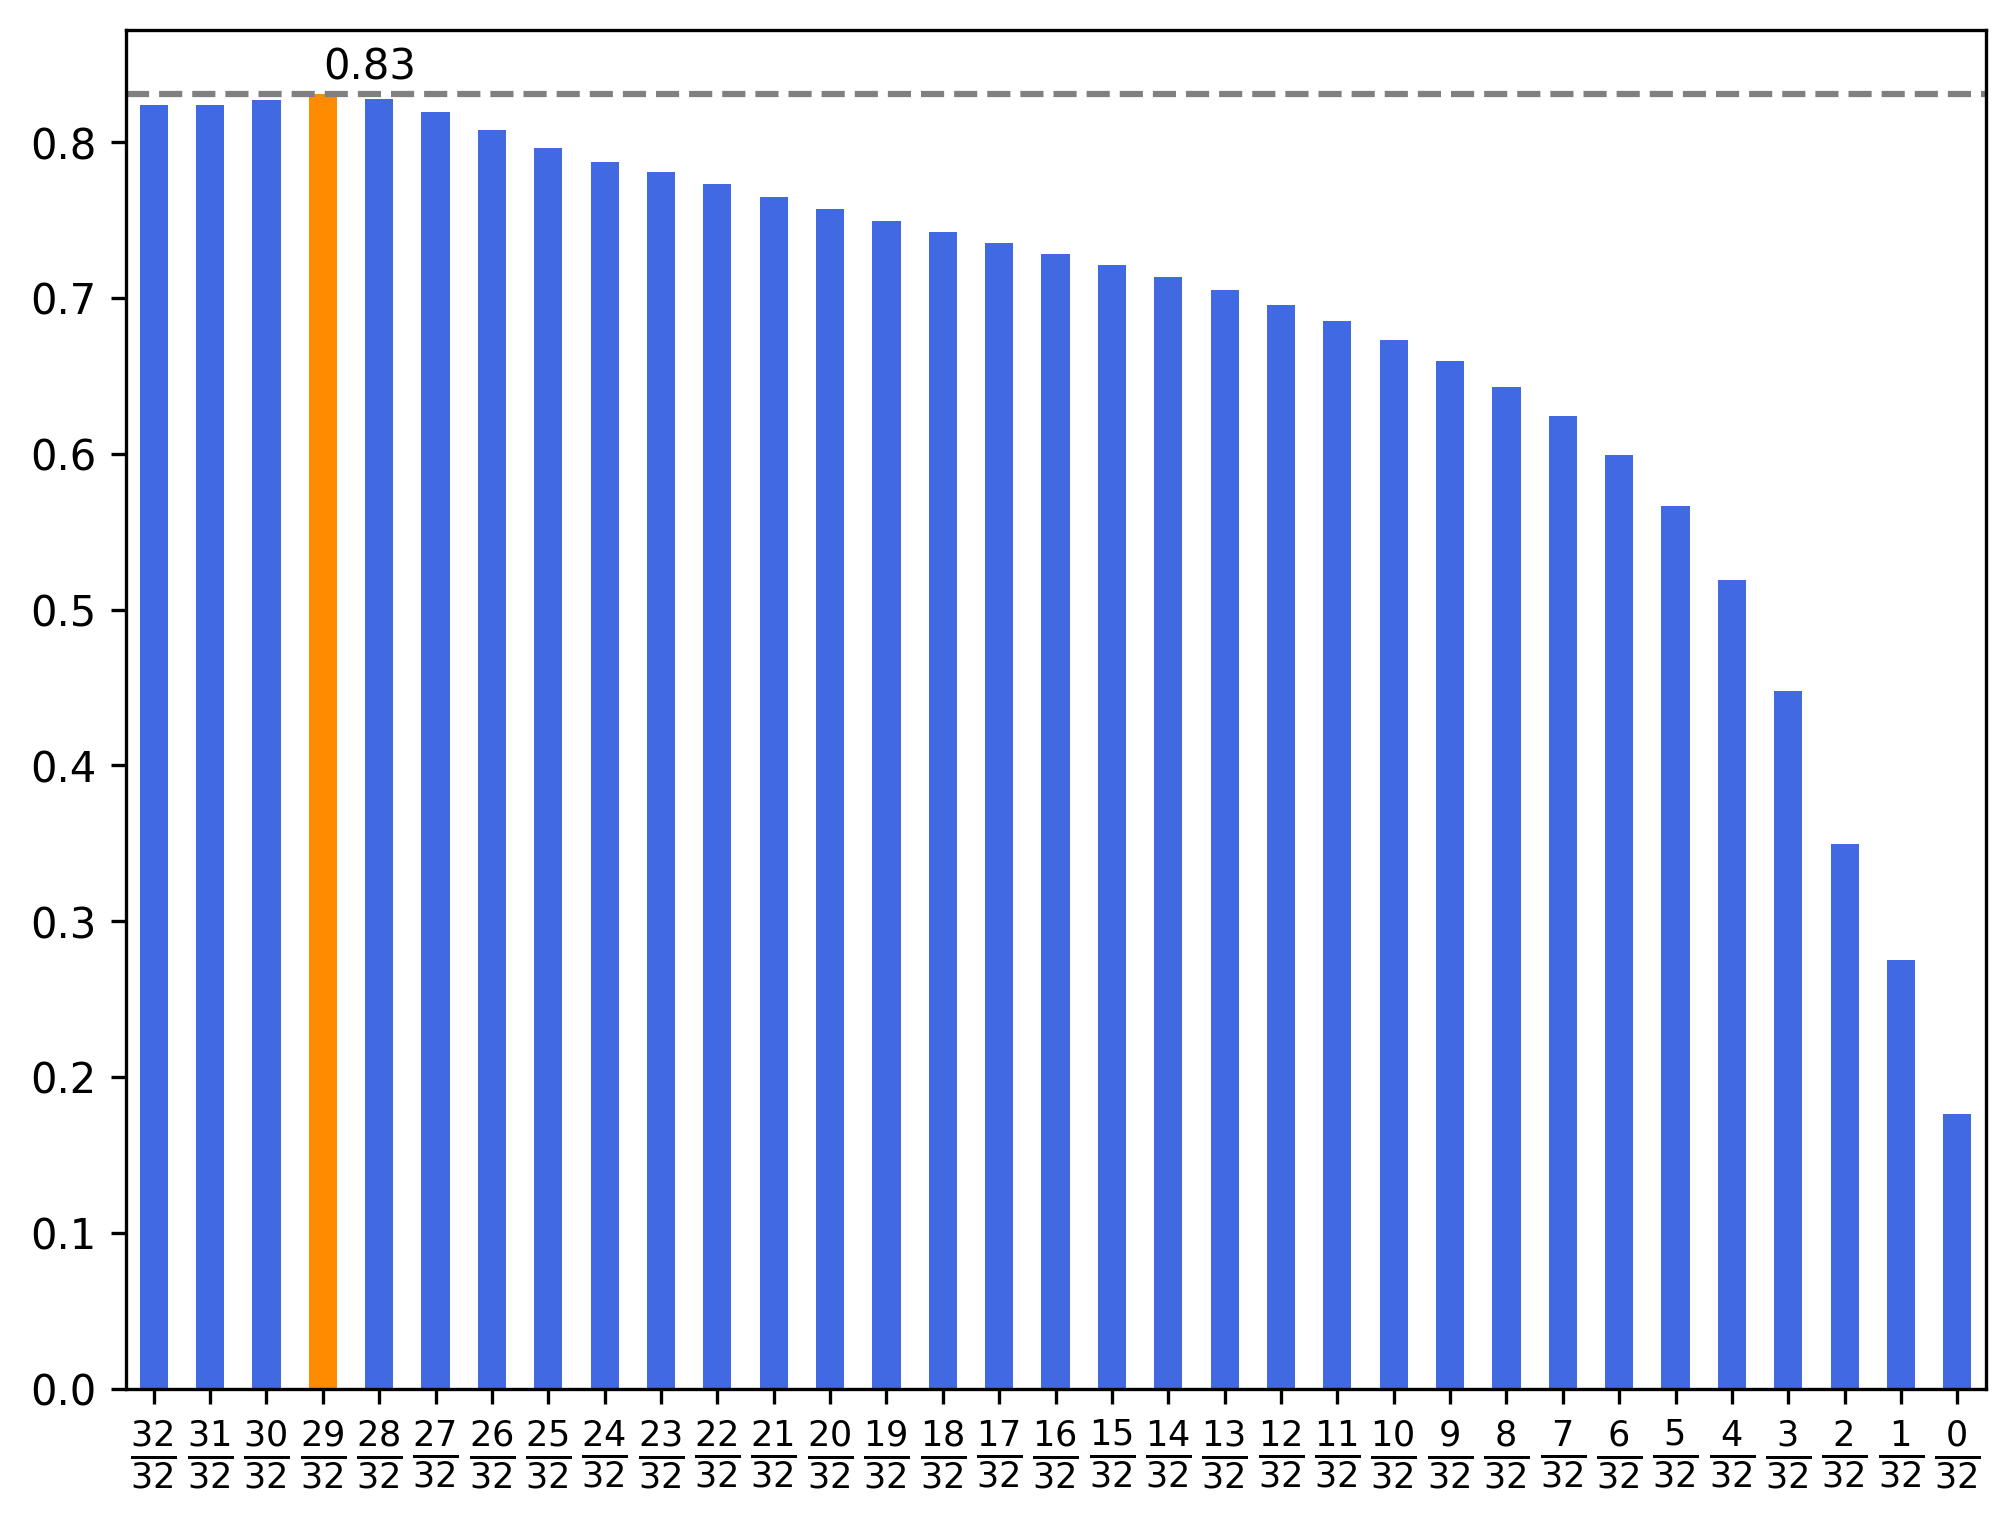

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))

consensus_acc = abs(consensus_cm.sort_index(
    ascending=False)).apply(lambda s: (s['tp'] + s['tn']) / sum(s),
                            axis=1).rename(columns={0: 'Balanced Acc'})
colors = ["royalblue"] * len(consensus_acc)
colors[len(consensus_acc) -
       consensus_acc.sort_values(ascending=False).index[0] - 1] = "darkorange"
ax = consensus_acc.plot.bar(ax=ax, color=colors)
ax.set_xticklabels([
    r'$\frac{{{}}}{{{}}}$'.format(l.get_text(),
                                  len(consensus_cm) - 1)
    for l in ax.get_xticklabels()
])
ax.tick_params(axis='x', which='both', rotation=0, labelsize=12)
maxacc = consensus_acc.max()
ax.axhline(maxacc, c='grey', linestyle='--')
ax.text(
    len(consensus_acc) - consensus_acc.sort_values(ascending=False).index[0] -
    1, maxacc + 0.01, round(maxacc, 2));

Accuracy distribution for each consensus threshold. Bar of max threshold is highlighted in orange.

### Percentage of correct/incorrect classifications
Percentage of correct and incorrect classifications for nositives (defined by DisProt), negatives (defined by PDB) and undefined residues for each predictor.

In [40]:
nopdb = pd.read_csv(get_fname(reference, 'simple-nopdb', results_dir,
                              'scores'),
                    index_col=[0])
pdb = pd.read_csv(get_fname(reference, 'pdb', results_dir, 'scores'),
                  index_col=[0])

pos_cls = ['TP', 'FN']
neg_cls = ['TN', 'FP']

a = nopdb[pos_cls].T.set_index(
    pd.MultiIndex.from_product([['DisProt'], pos_cls])).T
b = pdb[neg_cls].T.set_index(pd.MultiIndex.from_product([['PDB'], neg_cls])).T
c = nopdb[neg_cls].T.set_index(
    pd.MultiIndex.from_product([['Undefined'], neg_cls])).T

nopdb_cls = pd.concat([a, b, c], sort=False, axis=1).T.groupby(level=0).apply(
    lambda g: g.apply(lambda s: s.apply(lambda x: x / s.sum()))).round(3) * 100
nopdb_cls.T

DisProt          PDB       Undefined      
                               TP    FN     TN    FP        TN    FP
D006_IUPred-short            56.2  43.8   94.7   5.3      66.2  33.8
D021_MobiDB-lite             41.1  58.9   98.6   1.4      77.2  22.8
D022_S2D-1                   86.7  13.3   47.3  52.7      22.3  77.7
D025_RawMSA                  68.2  31.8   93.1   6.9      60.6  39.4
D005_IUPred-long             64.5  35.5   92.5   7.5      58.9  41.1
D007_FoldUnfold              66.6  33.4   82.5  17.5      48.8  51.2
D004_IUPred2A-short          56.3  43.7   94.9   5.1      66.3  33.7
D033_DynaMine                 1.7  98.3  100.0   0.0      97.9   2.1
D001_PyHCA                   65.8  34.2   84.8  15.2      53.7  46.3
D009_GlobPlot                38.3  61.7   90.0  10.0      70.0  30.0
D014_fIDPnn                  30.0  70.0   98.7   1.3      93.0   7.0
D017_DisEMBL-465             38.7  61.3   95.2   4.8      76.1  23.9
D032_DFLpred                  9.4  90.6   89.0  11.0      89.4  10.6
D002_Predisorder             80.7  19.3   82.4  17.6      41.8  58.2
D026_AUCpreD                 68.7  31.3   95.5   4.5      54.0  46.0
D003_IUPred2A-long           63.4  36.6   92.8   7.2      59.6  40.4
D023_S2D-2                   85.8  14.2   50.4  49.6      24.7  75.3
D029_SPOT-Disorder2          75.9  24.1   95.1   4.9      45.8  54.2
D030_SPOT-Disorder-Single    55.6  44.4   97.7   2.3      65.3  34.7
D020_ESpritz-X               53.2  46.8   95.6   4.4      67.5  32.5
D024_DisoMine                57.4  42.6   91.0   9.0      67.3  32.7
D028_SPOT-Disorder1          74.8  25.2   94.2   5.8      48.8  51.2
D013_fIDPln                  50.5  49.5   94.6   5.4      79.3  20.7
D011_DISOPRED-3.1            64.5  35.5   93.9   6.1      49.9  50.1
D019_ESpritz-N               68.7  31.3   86.6  13.4      51.6  48.4
D016_DisEMBL-HL              53.0  47.0   74.4  25.6      63.8  36.2
D027_AUCpreD-np              57.3  42.7   96.5   3.5      65.1  34.9
D008_IsUnstruct              74.8  25.2   86.0  14.0      49.3  50.7
D018_ESpritz-D               35.2  64.8   95.6   4.4      88.4  11.6
D031_JRONN                   74.1  25.9   81.7  18.3      47.3  52.7
D015_VSL2B                   81.5  18.5   77.2  22.8      40.0  60.0
D010_DisPredict-2            41.6  58.4   81.6  18.4      72.5  27.5

### clustermap of binary predictions correlation 
Correlation of binary states between predictors.

In [41]:
tgt, preds = load_predstack(
    get_fname(reference, negatives, results_dir, 'predstack'))

In [42]:
pred_corr = pd.DataFrame(index=preds.keys(), columns=preds.keys())
pred_corr_pvals = pd.DataFrame(index=preds.keys(), columns=preds.keys())

for pi in preds:
    if '/' not in pi or pi.split('/')[0] in (str(minfpr_idx - 1),
                                             str(minfnr_idx - 1)):
        for pj in preds:
            if '/' not in pj or pj.split('/')[0] in (str(minfpr_idx),
                                                     str(minfnr_idx)):
                r, p = pearsonr(preds[pi], preds[pj])
                pred_corr.loc[pi][pj] = r
                pred_corr_pvals.loc[pi][pj] = p

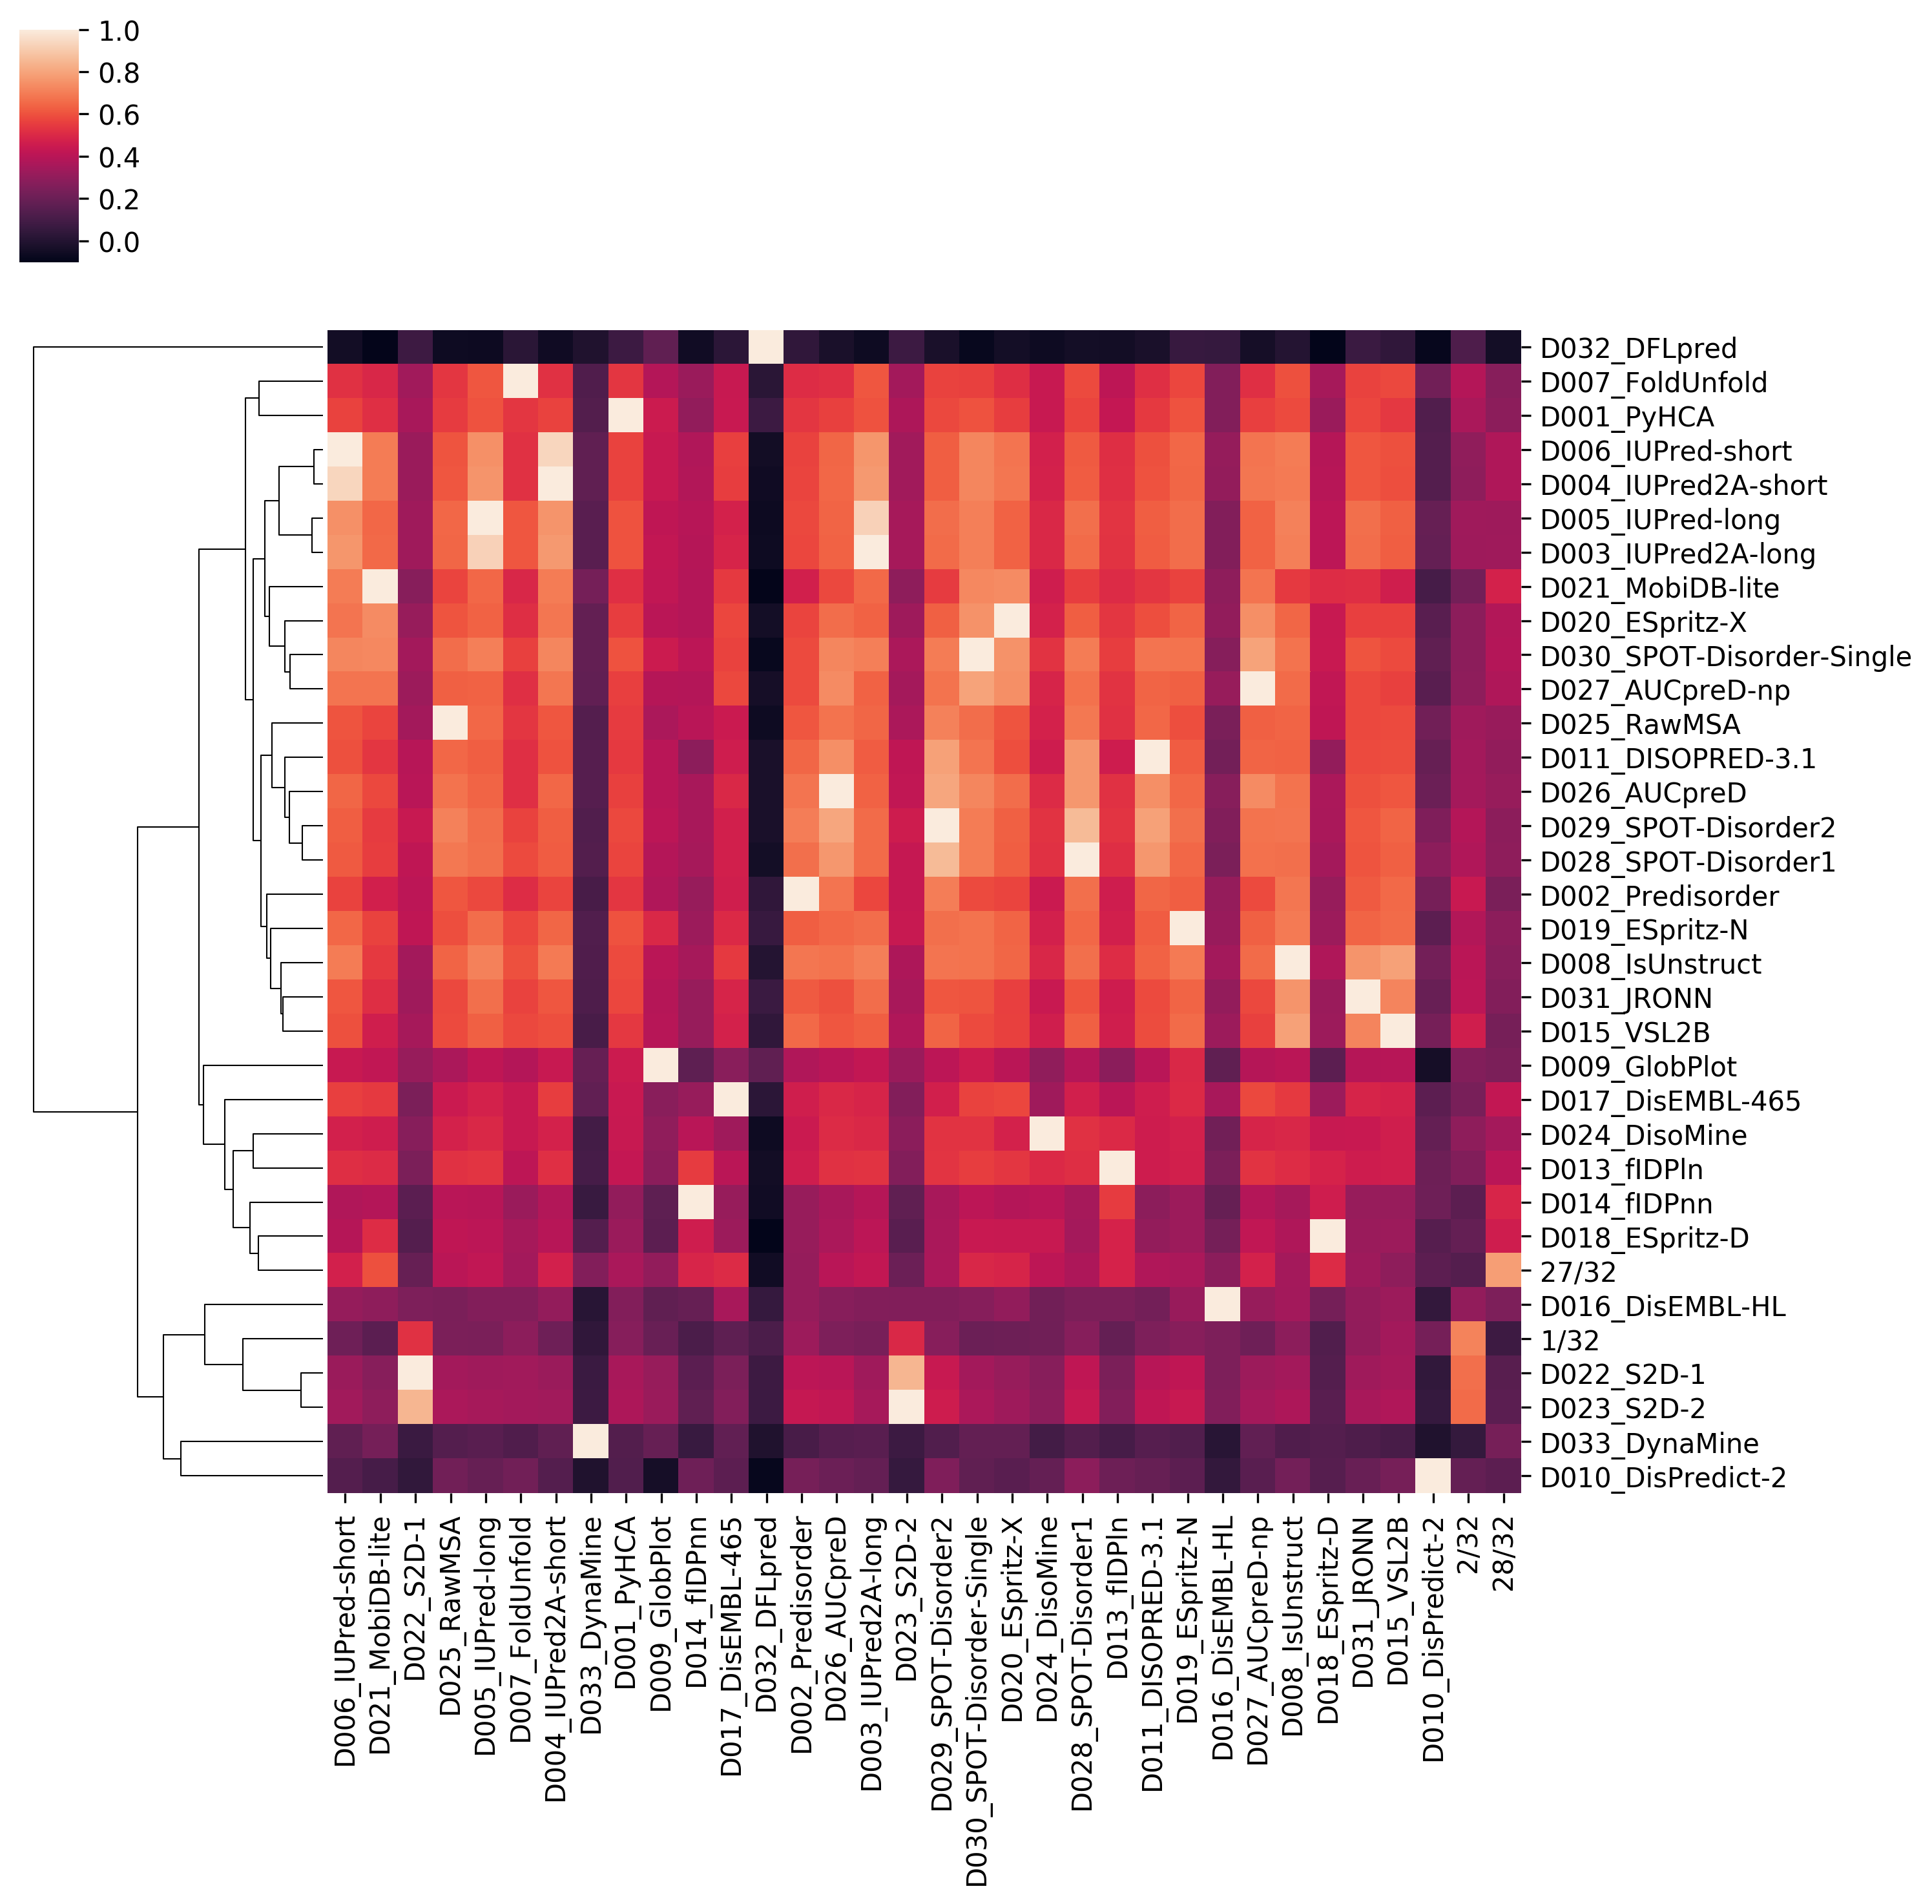

In [43]:
cax = sns.clustermap(pred_corr.dropna(0, how='all').dropna(
    1, how='all').astype(float),
                     col_cluster=None);

Heatmap of the correlation of binary prediction states for each couple of predictors. Pearson R is calculated between all predictions. Clustering is based on Euclidean distance calculated over an array (column) of R correlation coefficients.

## Fully disordered targets
Statistics calculated for the subset of targets that are reported as completely disordered in DisProt.

### Correctly and incorrectly classified full IDPs
Number of correctly and incorrectly classified full IDPs with a prediction tolerance of $5\%$.

In [44]:
full_idps = target_scores[pos[pos['ID position'] == 'full'].index]

metrics_lbl = [
    'bal_acc', 'fpr', 'fscore', 'fscore_n', 'mcc', 'precision', 'precision_n',
    'recall', 'recall_n'
]
preds = full_idps.index.get_level_values(0).unique()
full_idps = full_idps.drop(pd.MultiIndex.from_product([preds, metrics_lbl]))

correctly_classified_fidp = (full_idps.groupby(
    level=0).apply(lambda g: g.iloc[3, :] / g.iloc[3, :] + g.iloc[0, :]) >=
                             0.95).apply(
                                 sum,
                                 axis=1).to_frame().rename(columns={0: 'TP'})
correctly_classified_fidp[
    'FN'] = full_idps.columns.values.size - correctly_classified_fidp['TP']
# correctly_classified_fidp.sort_values(by="TP", ascending=False)

partial_idps = target_scores.drop(pos[pos['ID position'] == 'full'].index,
                                  axis=1)
lens = {
    tgt: refdict[tgt]["states"].size
    for tgt in partial_idps.columns.values
}
# drop metrics for each predictor
partial_idps = partial_idps.drop(
    pd.MultiIndex.from_product([preds, metrics_lbl]))
# identify targets predicted as fully disordered (5% tollerance)
incorrectly_classified_fidp = (partial_idps.groupby(
    level=0).apply(lambda g: (g.iloc[3, :] + g.iloc[1, :]) / g.sum()) >=
                               0.95).sum(axis=1).to_frame().rename(
                                   columns={0: 'FP'})
incorrectly_classified_fidp[
    'TN'] = partial_idps.columns.values.size - incorrectly_classified_fidp['FP']

df = pd.concat([correctly_classified_fidp, incorrectly_classified_fidp],
               axis=1,
               sort=False).sort_values(["TP", "TN"], ascending=[False, False])

del df.index.name

df.columns = pd.MultiIndex.from_arrays([['Positives'] * 2 + ["Negatives"] * 2, ['TP', 'FN', "FP ", 'TN']], names=['Actual', 'Predicted'])
df

Actual                    Positives     Negatives     
Predicted                        TP  FN       FP    TN
D009_GlobPlot                    44   0         0  602
D016_DisEMBL-HL                  44   0         0  602
D017_DisEMBL-465                 44   0         0  602
random_chain                     44   0         0  602
D006_IUPred-short                44   0         1  601
random_chunk                     44   0         1  601
D004_IUPred2A-short              44   0         2  600
D019_ESpritz-N                   44   0         4  598
D001_PyHCA                       44   0         5  597
D011_DISOPRED-3.1                44   0         6  596
D020_ESpritz-X                   44   0         6  596
D030_SPOT-Disorder-Single        44   0         7  595
D027_AUCpreD-np                  44   0        11  591
D002_Predisorder                 44   0        13  589
D008_IsUnstruct                  44   0        14  588
D026_AUCpreD                     44   0        15  587
D015_VSL2B                       44   0        24  578
D029_SPOT-Disorder2              44   0        28  574
D028_SPOT-Disorder1              44   0        31  571
D023_S2D-2                       44   0        33  569
D024_DisoMine                    44   0        55  547
D022_S2D-1                       44   0        57  545
cons                             44   0       160  442
D010_DisPredict-2                43   1        18  584
D025_RawMSA                      43   1        20  582
D013_fIDPln                      43   1        41  561
naive-pdb                        43   1       138  464
D003_IUPred2A-long               42   2         6  596
D005_IUPred-long                 42   2         6  596
D031_JRONN                       42   2         6  596
D014_fIDPnn                      42   2        16  586
D018_ESpritz-D                   42   2        52  550
naive-gene3d                     42   2       159  443
D007_FoldUnfold                  41   3       156  446
D021_MobiDB-lite                 37   7         2  600
D032_DFLpred                     13  31         0  602
D033_DynaMine                    13  31         0  602

In [45]:
def iterate_prediction_files(ppath, bpath=None):
    if bpath is not None:
        bfiles = [
            os.path.join(bpath, "_".join([reference, negatives, m]) + ".txt")
            for m in ['cons', 'naive-new-gene3d-r_simple', 'naive-new-pdb-r_simple']
        ]
    else:
        bfiles = []
    pfiles = [os.path.join(ppath, p) for p in os.listdir(ppath) if p[0] == "D"]
    for pred_file in pfiles + bfiles:
        pred_file = os.path.join(ppath, pred_file)
        pred_name = os.path.basename(os.path.splitext(pred_file)[0])
        yield pred_file, pred_name


def strip_split(string):
    if string:
        return string.strip('\n').rsplit('\t')


def parse_prediction(predfile, reference_ids, label=None):
    preds = {}
    reference_ids = set(reference_ids)

    with open(predfile) as fhandle:
        faiter = (x[1] for x in groupby(fhandle, lambda line: line[0] == ">"))
        for header in faiter:
            header = next(header).strip()[1:]
            body = next(faiter)
            if header in reference_ids:
                positions, _, scores, states = zip(*map(strip_split, body))
                if scores[0]:
                    preds[header] = np.array(scores, dtype=np.float).mean()
    return pd.Series(preds,
                     name=os.path.basename(os.path.splitext(predfile)[0]))


id_content_pred = pd.DataFrame()
for pf, pn in iterate_prediction_files(prediction_path, baseline_dir):
    p = parse_prediction(pf, refdict.keys())
    id_content_pred = pd.concat([id_content_pred, p], axis=1, sort=False)

### Full IDPs ROC
ROC for the classification power of Full IDPs. Average disorder scores for each target is compared to full IDPs (positives) and partial IDPs (negatives). $5\%$ prediction tolerance is applied.

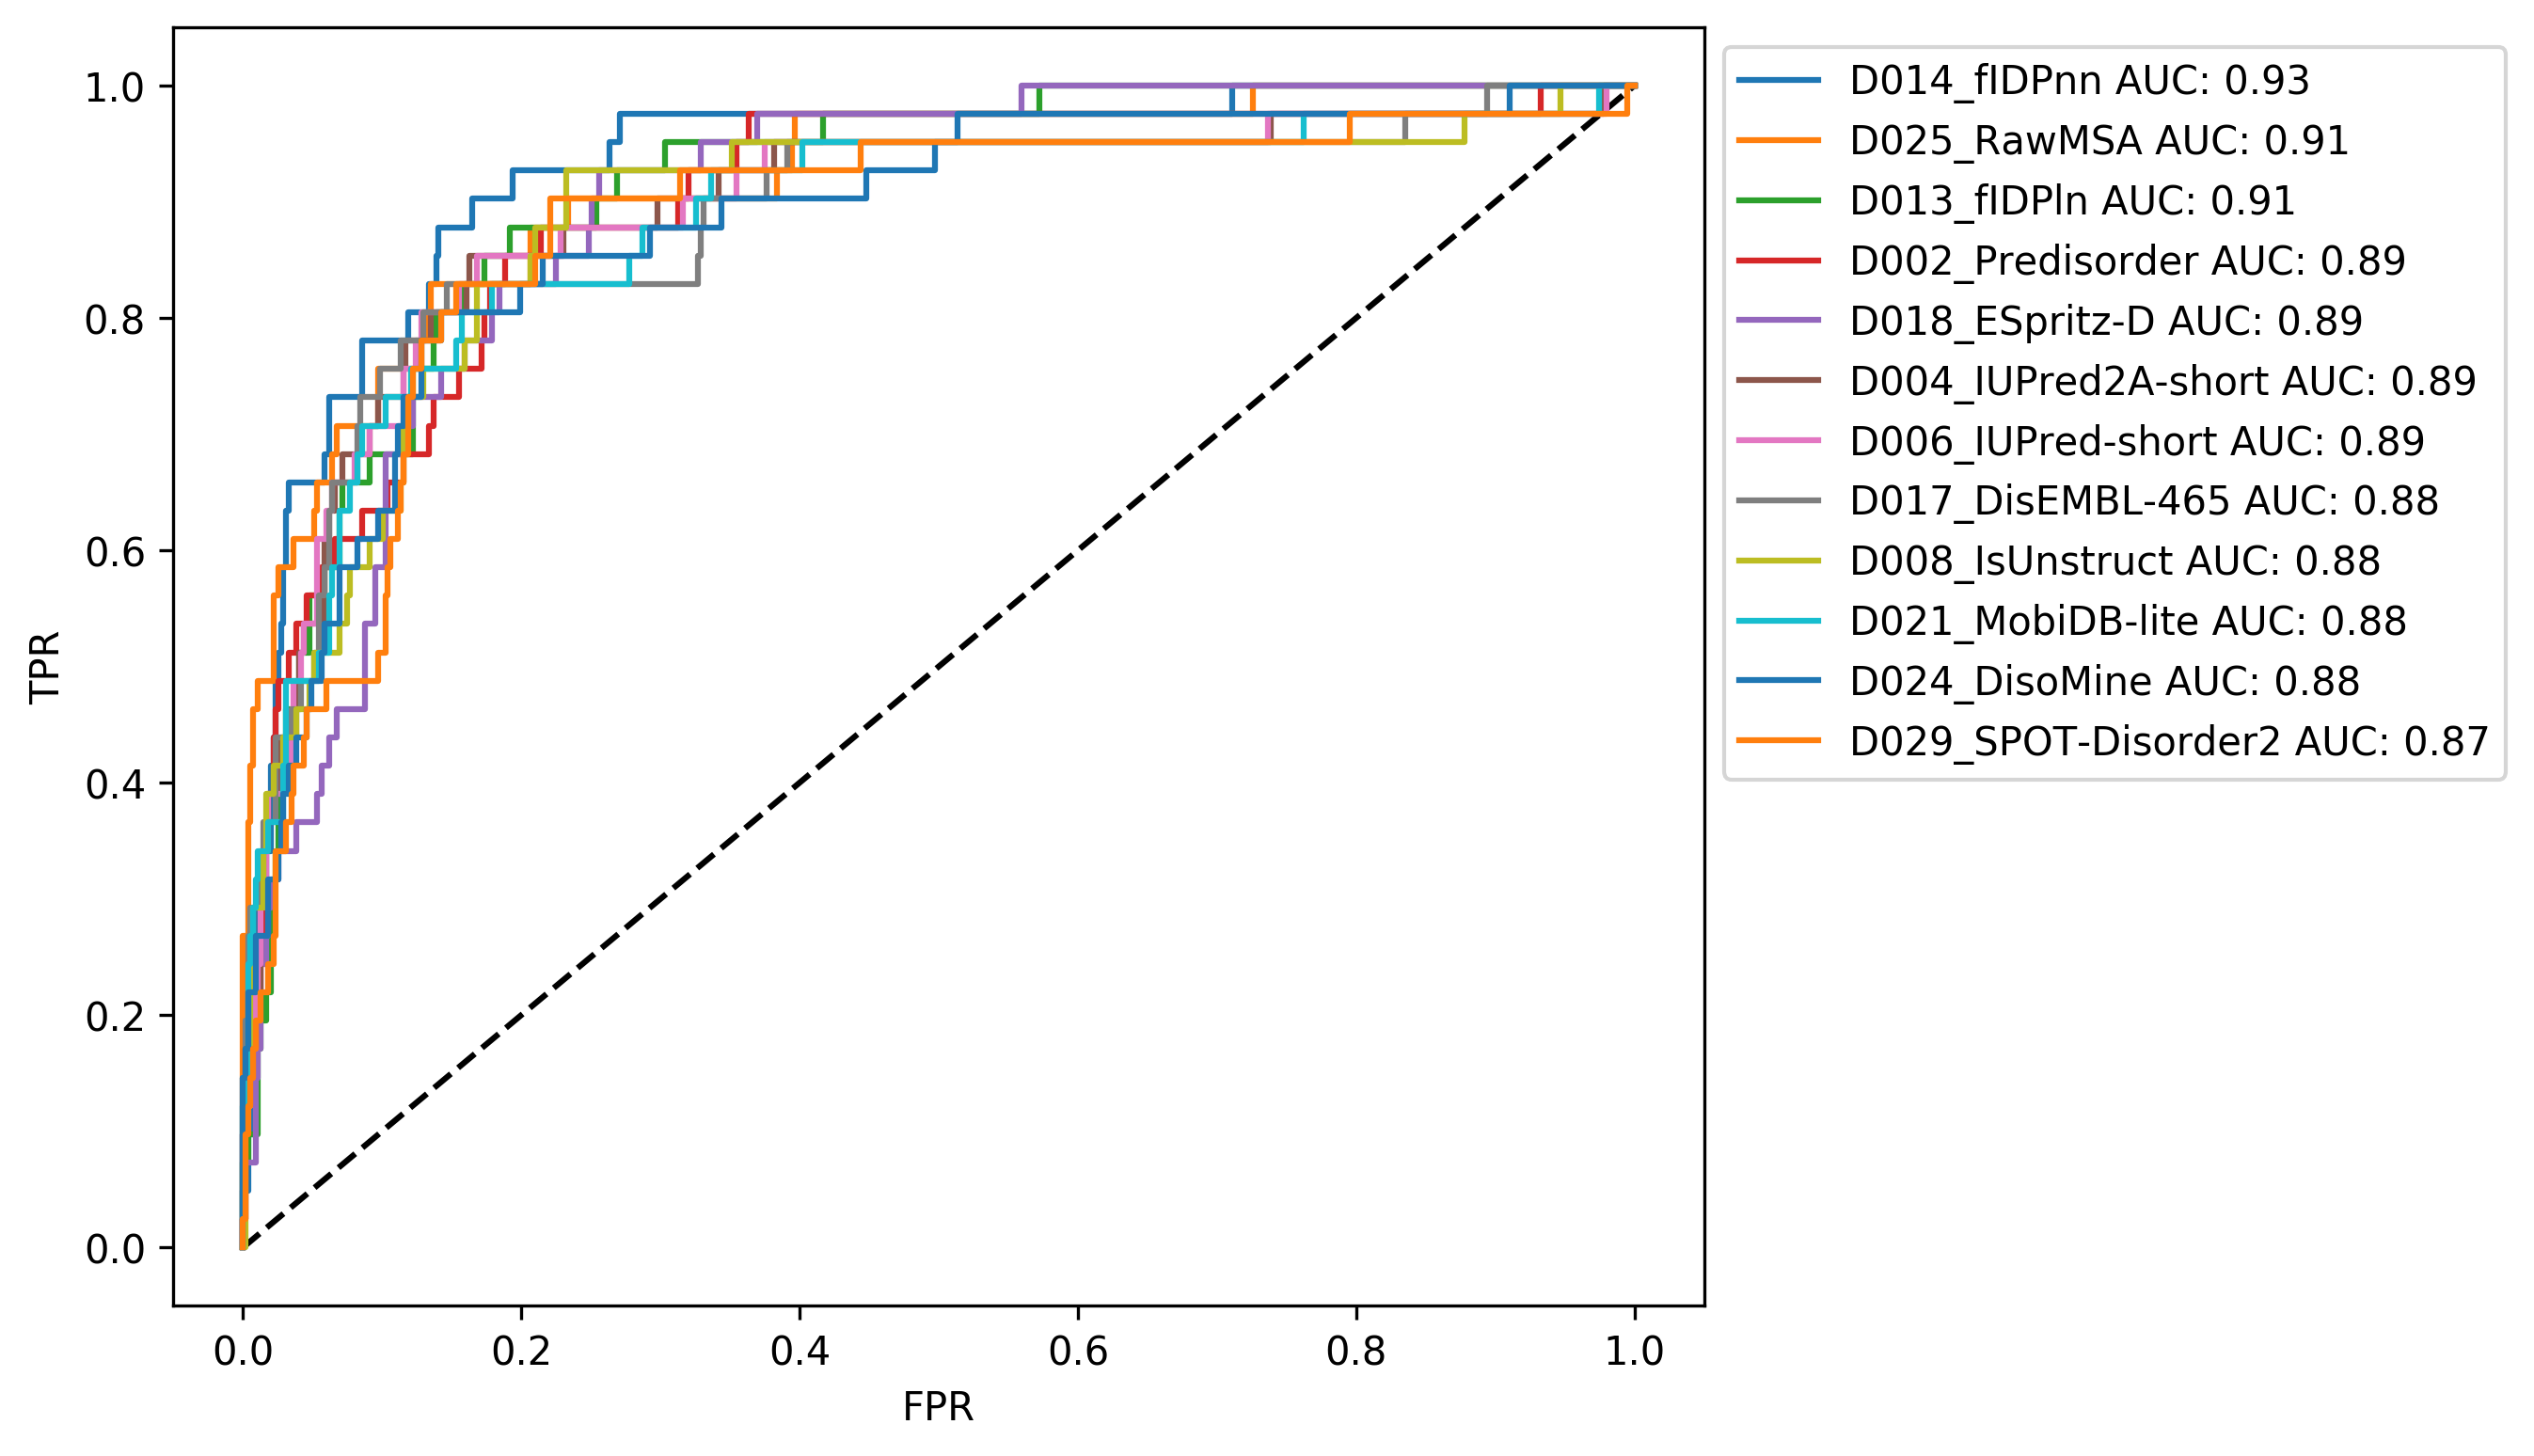

In [46]:
id_content_pred = id_content_pred.dropna(axis=1, how='all').dropna(axis=0,
                                                                   how='any')
id_content_ref = np.greater_equal(id_content,
                                  0.95).astype(int).loc[id_content_pred.index]

fullid_rocs = id_content_pred.apply(lambda col: metrics.roc_curve(
    id_content_ref.values, col.values)).to_dict()
fullid_aucs = id_content_pred.apply(lambda col: metrics.roc_auc_score(
    id_content_ref.values, col.values)).to_dict()

fig, ax = plt.subplots(figsize=(7, 6))
ax.plot([0, 1], [0, 1], linestyle='--', color='k')
for pred, (x, y, thr) in sorted(fullid_rocs.items(),
                                key=lambda t: fullid_aucs[t[0]],
                                reverse=True)[:12]:
    ax.plot(x, y, label="{} AUC: {:.2f}".format(pred, fullid_aucs[pred]))
    ax.legend(bbox_to_anchor=(1, 1), loc=2)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

FPR on the $x$ axis, TPR on the $y$ axis. Methods are sorted by their AUC. Only first 12 methods are shown.